# 데이터 셋 불러오기

데이터 출처 : 중소벤처기업부, Korea AI Manufacturing Platform(KAMP),
CNC머신 AI데이터셋, KAIST(UNIST, 이피엠솔루션즈), 2020.12.14.,
 https://kamp-ai.kr

## 데이터 설명:

    - 자동차 앞유리 사이드 몰딩 사출성형기의 2020년 10월 16일 ~ 2020년 11월 19일 까지의 1개월간의 생산 데이터 
    - unlabeled data : 795316, labeled data : 7996

## 문제 정의:

 1. 생산 단계에서 불량품을 잡아내지 못하고 후 단계로 유통을 하였을 경우 사슬 효과에 의하여 이를 수습하기 위하여 훨씬 더 큰 비용이 지출됨

> - 통상적으로 불량품 검사는 생산 시에 생산 기기 2 대 당 한명 꼴로 있는 작업자가 육안으로 표면에 보이는 결함에 대해 1차 검수 후, 일부 표본을 뽑아 CT 검사를 진행하는 표본 검사를 통하여 결함품을 검수함

> - 표본 검사를 통한 결함품 검수는 전체 생산 제품들 중 불량품을 걸러 낼수 없으며, 실시간으로 어떤 조건에서 결함이 발생했는지 유무를 확인 할 수 없음


 2. 자동차 산업에서는 현대, 기아차와 같은 완성차 업체 아래 n 차 벤더 사들이 부품을 제작하여 납품하며, 납품시 불량률은 추후 발주량에 영향을 주게됨 
> -> 불량을 잡아내지 못하여 생기는 실질적/ 잠재적 비용이 결함 탐지 머신러닝 시스템을 구축하고 유지하는데 드는 비용에 비하여 현저히 높음

 3. 결함 감지 시스템이 충분한 신뢰도를 확보한다면, 불량품 검수에 대한 인건비 등의 비용을 줄일 수 있으며 이는 회사의 가격경쟁력에 기여할 수 있음





*-> 제품을 생산할때 마다 생성되는 머신 데이터를 학습하여 제품의 양품/불량품 여부를 "분류"하는 머신러닝 모델을 만들어 실시간으로 결함품을 걸러내는 시스템을 만들고자 함*


가설 :
1. 분류 문제를 통하여 결함품을 분류 해 낼수 있음

2. 사출 공정은 주조 공정의 일부로 온도가 결함 발생에 영향을 줄 것

3. 사슬 효과에 의해 불량품을 양품으로 잘못 판단하는 것이 양품을 불량품으로 잘못 판단 하는것 보다 치명적임

In [1]:
!pip3 install imbalanced-learn
!pip3 install category_encoders
!pip3 install pdpbox
!pip3 install eli5
!pip3 install hyperopt
!pip3 install xgboost
!pip install pandas-profiling

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 3.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 34.0 MB 1.3 MB/s 
     |████████████████████████████████| 13.1 MB 37.5 MB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.1-py3-none-any.whl size=35758224 sha256=216e6ea5fb602c4ad48820414b2a73699ab2de4d2c5b77efe6d3fbdd4bb52b10
  Stored in directory: /root/.cache/pip/wheels/f4/d0/1a/b80035625c53131f52906a6fc4dd690d8efd2bf8af6a4015eb
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=13a68e07c5c8207e8ceb14380a8a411b35d56fbce5c112e2bf339398b02a04e2
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successful

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 5.2 MB/s 
     |████████████████████████████████| 133 kB 59.1 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=10a689477c776ff451f9bb25da0428367c67189cc5a7c747d392f1eac6a342ad
  Stored in directory: /root/.cache/pip/wheels/cc/3c/96/3ead31a8e6c20fc0f1a707fde2e05d49a80b1b4b30096573be
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.2 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheel

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('labeled_data.csv')
df

,_id,TimeStamp,PART_FACT_PLAN_DATE,PART_FACT_SERIAL,PART_NAME,EQUIP_CD,EQUIP_NAME,PassOrFail,Reason,Injection_Time,...,Mold_Temperature_3,Mold_Temperature_4,Mold_Temperature_5,Mold_Temperature_6,Mold_Temperature_7,Mold_Temperature_8,Mold_Temperature_9,Mold_Temperature_10,Mold_Temperature_11,Mold_Temperature_12
0,5f8928bb9c0189cc666ef19b,2020-10-16 04:57:47,2020-10-16 오전 12:00:00,24,CN7 W/S SIDE MLD'G RH,S14,650톤-우진2호기,Y,None,9.59,...,24.799999,27.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5f8928de9c0189cc666ef20b,2020-10-16 04:58:48,2020-10-16 오전 12:00:00,24,CN7 W/S SIDE MLD'G RH,S14,650톤-우진2호기,Y,None,9.60,...,24.799999,27.600000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5f8928df9c0189cc666ef213,2020-10-16 04:58:48,2020-10-16 오전 12:00:00,23,CN7 W/S SIDE MLD'G LH,S14,650톤-우진2호기,Y,None,9.60,...,24.799999,27.600000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5f8928f39c0189cc666ef25e,2020-10-16 04:59:48,2020-10-16 오전 12:00:00,23,CN7 W/S SIDE MLD'G LH,S14,650톤-우진2호기,Y,None,9.59,...,25.000000,27.600000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5f8928f59c0189cc666ef265,2020-10-16 04:59:48,2020-10-16 오전 12:00:00,24,CN7 W/S SIDE MLD'G RH,S14,650톤-우진2호기,Y,None,9.59,...,25.000000,27.600000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7991,5fa112859c0189cc66dabe34,2020-11-03 08:17:36,2020-11-03 오전 12:00:00,6,CN7 W/S SIDE MLD'G LH,S14,650톤-우진2호기,Y,None,9.60,...,21.000000,22.400000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7992,5fa112869c0189cc66dabe42,2020-11-03 08:18:37,2020-11-03 오전 12:00:00,7,CN7 W/S SIDE MLD'G RH,S14,650톤-우진2호기,Y,None,9.60,...,21.000000,22.400000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7993,5fa112879c0189cc66dabe50,2020-11-03 08:18:37,2020-11-03 오전 12:00:00,6,CN7 W/S SIDE MLD'G LH,S14,650톤-우진2호기,Y,None,9.60,...,21.000000,22.400000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7994,5fa112bb9c0189cc66dac22a,2020-11-03 08:19:35,2020-11-03 오전 12:00:00,6,CN7 W/S SIDE MLD'G LH,S14,650톤-우진2호기,Y,None,9.60,...,21.000000,22.299999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 1. EDA

In [3]:
df.columns

Index(['_id', 'TimeStamp', 'PART_FACT_PLAN_DATE', 'PART_FACT_SERIAL',
       'PART_NAME', 'EQUIP_CD', 'EQUIP_NAME', 'PassOrFail', 'Reason',
       'Injection_Time', 'Filling_Time', 'Plasticizing_Time', 'Cycle_Time',
       'Clamp_Close_Time', 'Cushion_Position', 'Switch_Over_Position',
       'Plasticizing_Position', 'Clamp_Open_Position', 'Max_Injection_Speed',
       'Max_Screw_RPM', 'Average_Screw_RPM', 'Max_Injection_Pressure',
       'Max_Switch_Over_Pressure', 'Max_Back_Pressure',
       'Average_Back_Pressure', 'Barrel_Temperature_1', 'Barrel_Temperature_2',
       'Barrel_Temperature_3', 'Barrel_Temperature_4', 'Barrel_Temperature_5',
       'Barrel_Temperature_6', 'Barrel_Temperature_7', 'Hopper_Temperature',
       'Mold_Temperature_1', 'Mold_Temperature_2', 'Mold_Temperature_3',
       'Mold_Temperature_4', 'Mold_Temperature_5', 'Mold_Temperature_6',
       'Mold_Temperature_7', 'Mold_Temperature_8', 'Mold_Temperature_9',
       'Mold_Temperature_10', 'Mold_Temperature_11', 

In [4]:
df.nunique()

_id                         5232
TimeStamp                   2625
PART_FACT_PLAN_DATE           13
PART_FACT_SERIAL              17
PART_NAME                      6
EQUIP_CD                       3
EQUIP_NAME                     3
PassOrFail                     2
Reason                         4
Injection_Time                36
Filling_Time                  35
Plasticizing_Time            121
Cycle_Time                    48
Clamp_Close_Time              13
Cushion_Position              22
Switch_Over_Position           3
Plasticizing_Position         49
Clamp_Open_Position            5
Max_Injection_Speed           55
Max_Screw_RPM                 11
Average_Screw_RPM             16
Max_Injection_Pressure        35
Max_Switch_Over_Pressure      69
Max_Back_Pressure             68
Average_Back_Pressure         53
Barrel_Temperature_1          67
Barrel_Temperature_2          60
Barrel_Temperature_3          45
Barrel_Temperature_4          79
Barrel_Temperature_5          56
Barrel_Tem

In [5]:
print(df.PART_FACT_SERIAL.nunique())
df.PART_FACT_SERIAL.unique()

17


array([24, 23, 13, 14, 17, 18,  9, 10, 12, 11,  2, 21, 22,  6,  7,  3,  4])

In [6]:
print(df.PART_NAME.nunique())
df.PART_NAME.unique()

6


array(["CN7 W/S SIDE MLD'G RH", "CN7 W/S SIDE MLD'G LH",
       "RG3 MOLD'G W/SHLD, LH", "RG3 MOLD'G W/SHLD, RH",
       'SP2 CVR ROOF RACK CTR, RH', "JX1 W/S SIDE MLD'G RH"], dtype=object)

In [7]:
print(df.EQUIP_CD.nunique())
df.EQUIP_CD.unique()

3


array(['S14', 'S01', 'S12'], dtype=object)

In [8]:
print(df.EQUIP_NAME.nunique())
df.EQUIP_NAME.unique()

3


array(['650톤-우진2호기', '1800TON-우진', '650톤-우진'], dtype=object)

In [9]:
print(df.Reason.nunique())
df.Reason.unique()

4


array(['None', '가스', '미성형', '초기허용불량'], dtype=object)

In [10]:
df.Mold_Temperature_12.unique()

array([0.])

In [11]:
df.Barrel_Temperature_7.unique()

array([ 0.        , 36.40000153])

In [12]:
df.PassOrFail.value_counts(normalize=True)

Y    0.991121
N    0.008879
Name: PassOrFail, dtype: float64

In [13]:
df.isnull().sum()

_id                         0
TimeStamp                   0
PART_FACT_PLAN_DATE         0
PART_FACT_SERIAL            0
PART_NAME                   0
EQUIP_CD                    0
EQUIP_NAME                  0
PassOrFail                  0
Reason                      0
Injection_Time              0
Filling_Time                0
Plasticizing_Time           0
Cycle_Time                  0
Clamp_Close_Time            0
Cushion_Position            0
Switch_Over_Position        0
Plasticizing_Position       0
Clamp_Open_Position         0
Max_Injection_Speed         0
Max_Screw_RPM               0
Average_Screw_RPM           0
Max_Injection_Pressure      0
Max_Switch_Over_Pressure    0
Max_Back_Pressure           0
Average_Back_Pressure       0
Barrel_Temperature_1        0
Barrel_Temperature_2        0
Barrel_Temperature_3        0
Barrel_Temperature_4        0
Barrel_Temperature_5        0
Barrel_Temperature_6        0
Barrel_Temperature_7        0
Hopper_Temperature          0
Mold_Tempe

In [14]:
df.duplicated().sum()

2764

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7996 entries, 0 to 7995
Data columns (total 45 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   _id                       7996 non-null   object 
 1   TimeStamp                 7996 non-null   object 
 2   PART_FACT_PLAN_DATE       7996 non-null   object 
 3   PART_FACT_SERIAL          7996 non-null   int64  
 4   PART_NAME                 7996 non-null   object 
 5   EQUIP_CD                  7996 non-null   object 
 6   EQUIP_NAME                7996 non-null   object 
 7   PassOrFail                7996 non-null   object 
 8   Reason                    7996 non-null   object 
 9   Injection_Time            7996 non-null   float64
 10  Filling_Time              7996 non-null   float64
 11  Plasticizing_Time         7996 non-null   float64
 12  Cycle_Time                7996 non-null   float64
 13  Clamp_Close_Time          7996 non-null   float64
 14  Cushion_

In [16]:
df.describe()

,PART_FACT_SERIAL,Injection_Time,Filling_Time,Plasticizing_Time,Cycle_Time,Clamp_Close_Time,Cushion_Position,Switch_Over_Position,Plasticizing_Position,Clamp_Open_Position,...,Mold_Temperature_3,Mold_Temperature_4,Mold_Temperature_5,Mold_Temperature_6,Mold_Temperature_7,Mold_Temperature_8,Mold_Temperature_9,Mold_Temperature_10,Mold_Temperature_11,Mold_Temperature_12
count,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,...,7996.000000,7996.000000,7996.0,7996.0,7996.0,7996.0,7996.0,7996.0,7996.0,7996.0
mean,11.248749,8.242189,3.896309,16.209505,59.900902,7.064088,653.408195,0.330320,66.054484,544.244111,...,22.145260,23.522574,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,5.005191,3.107724,1.284451,1.443720,0.885680,0.136595,10.165106,14.654889,5.418233,236.351404,...,1.177468,1.356586,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,2.000000,1.050000,0.930000,10.920000,58.840000,5.160000,11.100000,0.000000,53.549999,4.630000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,9.000000,9.520000,4.400000,16.580000,59.520000,7.110000,653.429993,0.000000,68.250000,647.989990,...,21.400000,22.700001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,10.000000,9.560000,4.440000,16.799999,59.520000,7.120000,653.440002,0.000000,68.339996,647.989990,...,22.000000,23.400000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,13.000000,9.590000,4.470000,16.889999,59.560001,7.120000,653.450012,0.000000,68.489998,647.989990,...,22.900000,24.200001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,24.000000,16.309999,8.270000,21.120001,66.860001,7.180000,655.080017,655.309998,68.860001,883.700012,...,25.299999,27.799999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


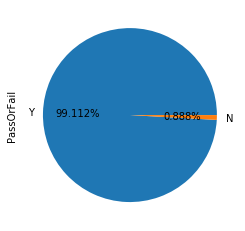

In [17]:
target = 'PassOrFail'
df[target].value_counts(normalize=True).plot.pie(autopct='%.3f%%')

1. _id 칼럼은 고유치로 데이터 분석에는 무의미함
2. Target은 PassOrFail
3. 센서값이 0으로 구성된 mold_temperature 은 drop
4. EQUIP_CD 와 EQUIP_NAME 은 같은 기계를 의미함(둘 중 하나 drop)
5.  weight or sampling 필요
6. 결함품 중 Reason이 안달려있는 데이터는 없음 == Reason이 None이 아닌 데이터 중 결함이 아닌 데이터는 없음 -> Reason을 학습하게 될 경우 data leakage 발생
7. 주조는 온도에 영향을 받으므로 날짜(TimeStamp)가 변함에 따라 기온의 변화 또한 영향이 없진않을것으로 생각 되지만, 데이터가 10~11월 1달간의 데이터로 온도의 변화가 크지 않을것으로 생각되고, 4계절의 데이터가 누적된것이 아니기에 해당 기간을 벗어 나는 데이터에 대한 예측이 어려울것으로 보임, 단 시간대에 따른 차이는 존재할 가능성도 존재하므로 (온도, 노동자에 따른 변수) 시 데이터만 학습에 사용하려함
8. Switch over position 컬럼은 8000개 중 5개의 데이터를 제외하고 같은 값을 가지며 5개의 데이터는 모두 양품이므로 분류에 충분한 기준을 제공할수 있는 컬럼이 아님 -> drop

# 2. 전처리

In [18]:
data = df.drop(['_id','EQUIP_CD','Mold_Temperature_12','Mold_Temperature_11','Mold_Temperature_10','Mold_Temperature_9','Mold_Temperature_8','Mold_Temperature_7','Mold_Temperature_6','Mold_Temperature_5','Mold_Temperature_1','Mold_Temperature_2','PART_FACT_PLAN_DATE'],axis=1)
data

,TimeStamp,PART_FACT_SERIAL,PART_NAME,EQUIP_NAME,PassOrFail,Reason,Injection_Time,Filling_Time,Plasticizing_Time,Cycle_Time,...,Barrel_Temperature_1,Barrel_Temperature_2,Barrel_Temperature_3,Barrel_Temperature_4,Barrel_Temperature_5,Barrel_Temperature_6,Barrel_Temperature_7,Hopper_Temperature,Mold_Temperature_3,Mold_Temperature_4
0,2020-10-16 04:57:47,24,CN7 W/S SIDE MLD'G RH,650톤-우진2호기,Y,None,9.59,4.47,16.920000,59.520000,...,276.500000,274.700012,274.799988,269.200012,255.000000,229.699997,0.0,66.300003,24.799999,27.500000
1,2020-10-16 04:58:48,24,CN7 W/S SIDE MLD'G RH,650톤-우진2호기,Y,None,9.60,4.48,16.910000,59.580002,...,276.200012,275.500000,275.299988,270.799988,254.699997,229.500000,0.0,67.199997,24.799999,27.600000
2,2020-10-16 04:58:48,23,CN7 W/S SIDE MLD'G LH,650톤-우진2호기,Y,None,9.60,4.48,16.910000,59.580002,...,276.200012,275.500000,275.299988,270.799988,254.699997,229.500000,0.0,67.199997,24.799999,27.600000
3,2020-10-16 04:59:48,23,CN7 W/S SIDE MLD'G LH,650톤-우진2호기,Y,None,9.59,4.48,16.910000,59.560001,...,276.500000,275.000000,275.399994,271.100006,254.899994,230.000000,0.0,66.900002,25.000000,27.600000
4,2020-10-16 04:59:48,24,CN7 W/S SIDE MLD'G RH,650톤-우진2호기,Y,None,9.59,4.48,16.910000,59.560001,...,276.500000,275.000000,275.399994,271.100006,254.899994,230.000000,0.0,66.900002,25.000000,27.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7991,2020-11-03 08:17:36,6,CN7 W/S SIDE MLD'G LH,650톤-우진2호기,Y,None,9.60,4.48,16.620001,59.560001,...,276.500000,274.899994,275.100006,269.500000,255.600006,229.600006,0.0,66.099998,21.000000,22.400000
7992,2020-11-03 08:18:37,7,CN7 W/S SIDE MLD'G RH,650톤-우진2호기,Y,None,9.60,4.48,16.650000,59.560001,...,275.799988,275.299988,275.500000,270.700012,254.899994,230.000000,0.0,66.099998,21.000000,22.400000
7993,2020-11-03 08:18:37,6,CN7 W/S SIDE MLD'G LH,650톤-우진2호기,Y,None,9.60,4.48,16.650000,59.560001,...,275.799988,275.299988,275.500000,270.700012,254.899994,230.000000,0.0,66.099998,21.000000,22.400000
7994,2020-11-03 08:19:35,6,CN7 W/S SIDE MLD'G LH,650톤-우진2호기,Y,None,9.60,4.48,16.629999,59.580002,...,276.100006,275.799988,275.000000,271.299988,255.100006,230.199997,0.0,65.199997,21.000000,22.299999


In [19]:
data.nunique()

TimeStamp                   2625
PART_FACT_SERIAL              17
PART_NAME                      6
EQUIP_NAME                     3
PassOrFail                     2
Reason                         4
Injection_Time                36
Filling_Time                  35
Plasticizing_Time            121
Cycle_Time                    48
Clamp_Close_Time              13
Cushion_Position              22
Switch_Over_Position           3
Plasticizing_Position         49
Clamp_Open_Position            5
Max_Injection_Speed           55
Max_Screw_RPM                 11
Average_Screw_RPM             16
Max_Injection_Pressure        35
Max_Switch_Over_Pressure      69
Max_Back_Pressure             68
Average_Back_Pressure         53
Barrel_Temperature_1          67
Barrel_Temperature_2          60
Barrel_Temperature_3          45
Barrel_Temperature_4          79
Barrel_Temperature_5          56
Barrel_Temperature_6          37
Barrel_Temperature_7           2
Hopper_Temperature            94
Mold_Tempe

In [20]:
data=data.drop_duplicates()

In [21]:
data.shape

(5232, 32)

In [22]:
data.PassOrFail.value_counts()

Y    5172
N      60
Name: PassOrFail, dtype: int64

In [23]:
data.PassOrFail=data.PassOrFail.replace(['N','Y'],[1,0])

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [24]:
data.PassOrFail.value_counts()

0    5172
1      60
Name: PassOrFail, dtype: int64

In [25]:
data.rename(columns={'PassOrFail':'Defects'},inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [26]:
data.Defects.value_counts()

0    5172
1      60
Name: Defects, dtype: int64

In [27]:
data.columns

Index(['TimeStamp', 'PART_FACT_SERIAL', 'PART_NAME', 'EQUIP_NAME', 'Defects',
       'Reason', 'Injection_Time', 'Filling_Time', 'Plasticizing_Time',
       'Cycle_Time', 'Clamp_Close_Time', 'Cushion_Position',
       'Switch_Over_Position', 'Plasticizing_Position', 'Clamp_Open_Position',
       'Max_Injection_Speed', 'Max_Screw_RPM', 'Average_Screw_RPM',
       'Max_Injection_Pressure', 'Max_Switch_Over_Pressure',
       'Max_Back_Pressure', 'Average_Back_Pressure', 'Barrel_Temperature_1',
       'Barrel_Temperature_2', 'Barrel_Temperature_3', 'Barrel_Temperature_4',
       'Barrel_Temperature_5', 'Barrel_Temperature_6', 'Barrel_Temperature_7',
       'Hopper_Temperature', 'Mold_Temperature_3', 'Mold_Temperature_4'],
      dtype='object')

In [28]:
data

,TimeStamp,PART_FACT_SERIAL,PART_NAME,EQUIP_NAME,Defects,Reason,Injection_Time,Filling_Time,Plasticizing_Time,Cycle_Time,...,Barrel_Temperature_1,Barrel_Temperature_2,Barrel_Temperature_3,Barrel_Temperature_4,Barrel_Temperature_5,Barrel_Temperature_6,Barrel_Temperature_7,Hopper_Temperature,Mold_Temperature_3,Mold_Temperature_4
0,2020-10-16 04:57:47,24,CN7 W/S SIDE MLD'G RH,650톤-우진2호기,0,None,9.59,4.47,16.92,59.520000,...,276.500000,274.700012,274.799988,269.200012,255.000000,229.699997,0.0,66.300003,24.799999,27.500000
1,2020-10-16 04:58:48,24,CN7 W/S SIDE MLD'G RH,650톤-우진2호기,0,None,9.60,4.48,16.91,59.580002,...,276.200012,275.500000,275.299988,270.799988,254.699997,229.500000,0.0,67.199997,24.799999,27.600000
2,2020-10-16 04:58:48,23,CN7 W/S SIDE MLD'G LH,650톤-우진2호기,0,None,9.60,4.48,16.91,59.580002,...,276.200012,275.500000,275.299988,270.799988,254.699997,229.500000,0.0,67.199997,24.799999,27.600000
3,2020-10-16 04:59:48,23,CN7 W/S SIDE MLD'G LH,650톤-우진2호기,0,None,9.59,4.48,16.91,59.560001,...,276.500000,275.000000,275.399994,271.100006,254.899994,230.000000,0.0,66.900002,25.000000,27.600000
4,2020-10-16 04:59:48,24,CN7 W/S SIDE MLD'G RH,650톤-우진2호기,0,None,9.59,4.48,16.91,59.560001,...,276.500000,275.000000,275.399994,271.100006,254.899994,230.000000,0.0,66.900002,25.000000,27.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5227,2020-11-04 05:43:29,10,"RG3 MOLD'G W/SHLD, RH",650톤-우진2호기,0,None,1.07,0.94,13.12,61.779999,...,285.899994,284.899994,285.700012,274.899994,265.000000,234.899994,0.0,64.500000,22.500000,24.299999
5228,2020-11-04 05:43:29,9,"RG3 MOLD'G W/SHLD, LH",650톤-우진2호기,0,None,1.07,0.94,13.12,61.779999,...,285.899994,284.899994,285.700012,274.899994,265.000000,234.899994,0.0,64.500000,22.500000,24.299999
5229,2020-11-05 03:00:02,3,"RG3 MOLD'G W/SHLD, LH",650톤-우진2호기,0,None,1.07,0.94,12.96,61.779999,...,285.899994,284.899994,285.500000,274.399994,264.899994,235.100006,0.0,62.200001,22.299999,23.700001
5230,2020-11-05 03:00:02,4,"RG3 MOLD'G W/SHLD, RH",650톤-우진2호기,0,None,1.07,0.94,12.96,61.779999,...,285.899994,284.899994,285.500000,274.399994,264.899994,235.100006,0.0,62.200001,22.299999,23.700001


In [29]:
target = 'Defects'
data = data.drop(columns = 'Reason')
data.columns

Index(['TimeStamp', 'PART_FACT_SERIAL', 'PART_NAME', 'EQUIP_NAME', 'Defects',
       'Injection_Time', 'Filling_Time', 'Plasticizing_Time', 'Cycle_Time',
       'Clamp_Close_Time', 'Cushion_Position', 'Switch_Over_Position',
       'Plasticizing_Position', 'Clamp_Open_Position', 'Max_Injection_Speed',
       'Max_Screw_RPM', 'Average_Screw_RPM', 'Max_Injection_Pressure',
       'Max_Switch_Over_Pressure', 'Max_Back_Pressure',
       'Average_Back_Pressure', 'Barrel_Temperature_1', 'Barrel_Temperature_2',
       'Barrel_Temperature_3', 'Barrel_Temperature_4', 'Barrel_Temperature_5',
       'Barrel_Temperature_6', 'Barrel_Temperature_7', 'Hopper_Temperature',
       'Mold_Temperature_3', 'Mold_Temperature_4'],
      dtype='object')

In [30]:
data.Switch_Over_Position.unique()

array([  0.        , 655.30999756,  10.        ])

In [31]:
data.dtypes

TimeStamp                    object
PART_FACT_SERIAL              int64
PART_NAME                    object
EQUIP_NAME                   object
Defects                       int64
Injection_Time              float64
Filling_Time                float64
Plasticizing_Time           float64
Cycle_Time                  float64
Clamp_Close_Time            float64
Cushion_Position            float64
Switch_Over_Position        float64
Plasticizing_Position       float64
Clamp_Open_Position         float64
Max_Injection_Speed         float64
Max_Screw_RPM               float64
Average_Screw_RPM           float64
Max_Injection_Pressure      float64
Max_Switch_Over_Pressure    float64
Max_Back_Pressure           float64
Average_Back_Pressure       float64
Barrel_Temperature_1        float64
Barrel_Temperature_2        float64
Barrel_Temperature_3        float64
Barrel_Temperature_4        float64
Barrel_Temperature_5        float64
Barrel_Temperature_6        float64
Barrel_Temperature_7        

In [32]:
import datetime
#data['TimeStamp'] = data['Timestamp'].to_datetime()
#pd.to_datetime(data.TimeStamp).dt.strftime("%Y-%m-%d %H:%M:%S")
#date_base=dt.datetime(2020, 10,16,4,57,47)
data['TimeStamp']= data.TimeStamp.apply(pd.to_datetime)
data['Production_Hour']=data.TimeStamp.apply(lambda x : x.hour)
#date_data.apply(lambda x : x.hour)

In [33]:
import datetime as dt
#data['TimeStamp'].apply(lambda x:x.dt.strftime("%Y-%m-%d %H:%M:%S"))

In [34]:
data=data.drop(columns='TimeStamp')
data.Production_Hour.unique()

array([ 4,  5,  6,  7,  8, 23,  0,  1,  2,  3])

In [35]:
data.Barrel_Temperature_7.value_counts()

0.000000     5231
36.400002       1
Name: Barrel_Temperature_7, dtype: int64

In [36]:
data=data.drop(columns='Barrel_Temperature_7')

In [37]:
data.nunique()

PART_FACT_SERIAL             17
PART_NAME                     6
EQUIP_NAME                    3
Defects                       2
Injection_Time               36
Filling_Time                 35
Plasticizing_Time           121
Cycle_Time                   48
Clamp_Close_Time             13
Cushion_Position             22
Switch_Over_Position          3
Plasticizing_Position        49
Clamp_Open_Position           5
Max_Injection_Speed          55
Max_Screw_RPM                11
Average_Screw_RPM            16
Max_Injection_Pressure       35
Max_Switch_Over_Pressure     69
Max_Back_Pressure            68
Average_Back_Pressure        53
Barrel_Temperature_1         67
Barrel_Temperature_2         60
Barrel_Temperature_3         45
Barrel_Temperature_4         79
Barrel_Temperature_5         56
Barrel_Temperature_6         37
Hopper_Temperature           94
Mold_Temperature_3           56
Mold_Temperature_4           55
Production_Hour              10
dtype: int64

In [38]:
print(data.Clamp_Open_Position.unique())

[647.98999023   4.63000011 883.70001221  69.63999939  76.62999725]


In [39]:
data.Clamp_Open_Position.value_counts()

647.989990    3956
4.630000      1256
69.639999       18
883.700012       1
76.629997        1
Name: Clamp_Open_Position, dtype: int64

In [40]:
print(data.Switch_Over_Position.unique())

[  0.         655.30999756  10.        ]


In [41]:
data.Switch_Over_Position.value_counts()

0.000000      5227
655.309998       4
10.000000        1
Name: Switch_Over_Position, dtype: int64

In [42]:
data.query('Switch_Over_Position != 0.0')

,PART_FACT_SERIAL,PART_NAME,EQUIP_NAME,Defects,Injection_Time,Filling_Time,Plasticizing_Time,Cycle_Time,Clamp_Close_Time,Cushion_Position,...,Barrel_Temperature_1,Barrel_Temperature_2,Barrel_Temperature_3,Barrel_Temperature_4,Barrel_Temperature_5,Barrel_Temperature_6,Hopper_Temperature,Mold_Temperature_3,Mold_Temperature_4,Production_Hour
1697,9,"RG3 MOLD'G W/SHLD, LH",650톤-우진2호기,0,1.060000,0.94,12.90,61.779999,6.81,654.26001,...,285.500000,285.000000,285.100006,276.000000,265.200012,235.100006,66.300003,22.700001,23.700001,6
1698,10,"RG3 MOLD'G W/SHLD, RH",650톤-우진2호기,0,1.060000,0.94,12.90,61.779999,6.81,654.26001,...,285.500000,285.000000,285.100006,276.000000,265.200012,235.100006,66.300003,22.700001,23.700001,6
1869,9,"RG3 MOLD'G W/SHLD, LH",650톤-우진2호기,0,1.060000,0.94,12.94,61.779999,6.81,654.26001,...,285.600006,285.200012,285.000000,275.000000,265.399994,234.699997,65.699997,22.799999,23.900000,7
1870,10,"RG3 MOLD'G W/SHLD, RH",650톤-우진2호기,0,1.060000,0.94,12.94,61.779999,6.81,654.26001,...,285.600006,285.200012,285.000000,275.000000,265.399994,234.699997,65.699997,22.799999,23.900000,7
3021,2,"SP2 CVR ROOF RACK CTR, RH",1800TON-우진,0,16.309999,3.00,10.92,66.860001,5.16,11.10000,...,0.000000,266.700012,269.399994,270.799988,270.399994,264.299988,0.000000,0.000000,0.000000,5


In [43]:
data=data.drop(columns = 'Switch_Over_Position')

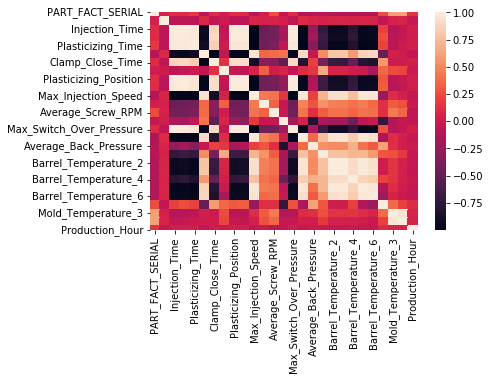

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

corr = data.corr()
sns.heatmap(corr)

In [ ]:
sns.pairplot(data)
plt.savefig('corr_map.png',dpi = 400)

In [46]:
data.dtypes

PART_FACT_SERIAL              int64
PART_NAME                    object
EQUIP_NAME                   object
Defects                       int64
Injection_Time              float64
Filling_Time                float64
Plasticizing_Time           float64
Cycle_Time                  float64
Clamp_Close_Time            float64
Cushion_Position            float64
Plasticizing_Position       float64
Clamp_Open_Position         float64
Max_Injection_Speed         float64
Max_Screw_RPM               float64
Average_Screw_RPM           float64
Max_Injection_Pressure      float64
Max_Switch_Over_Pressure    float64
Max_Back_Pressure           float64
Average_Back_Pressure       float64
Barrel_Temperature_1        float64
Barrel_Temperature_2        float64
Barrel_Temperature_3        float64
Barrel_Temperature_4        float64
Barrel_Temperature_5        float64
Barrel_Temperature_6        float64
Hopper_Temperature          float64
Mold_Temperature_3          float64
Mold_Temperature_4          

In [47]:
data.columns

Index(['PART_FACT_SERIAL', 'PART_NAME', 'EQUIP_NAME', 'Defects',
       'Injection_Time', 'Filling_Time', 'Plasticizing_Time', 'Cycle_Time',
       'Clamp_Close_Time', 'Cushion_Position', 'Plasticizing_Position',
       'Clamp_Open_Position', 'Max_Injection_Speed', 'Max_Screw_RPM',
       'Average_Screw_RPM', 'Max_Injection_Pressure',
       'Max_Switch_Over_Pressure', 'Max_Back_Pressure',
       'Average_Back_Pressure', 'Barrel_Temperature_1', 'Barrel_Temperature_2',
       'Barrel_Temperature_3', 'Barrel_Temperature_4', 'Barrel_Temperature_5',
       'Barrel_Temperature_6', 'Hopper_Temperature', 'Mold_Temperature_3',
       'Mold_Temperature_4', 'Production_Hour'],
      dtype='object')

In [48]:
target = 'Defects'
num_feature=['Injection_Time', 'Filling_Time', 'Plasticizing_Time', 'Cycle_Time',
       'Clamp_Close_Time', 'Cushion_Position', 'Plasticizing_Position',
       'Clamp_Open_Position', 'Max_Injection_Speed', 'Max_Screw_RPM',
       'Average_Screw_RPM', 'Max_Injection_Pressure',
       'Max_Switch_Over_Pressure', 'Max_Back_Pressure',
       'Average_Back_Pressure', 'Barrel_Temperature_1', 'Barrel_Temperature_2',
       'Barrel_Temperature_3', 'Barrel_Temperature_4', 'Barrel_Temperature_5',
       'Barrel_Temperature_6', 'Hopper_Temperature', 'Mold_Temperature_3',
       'Mold_Temperature_4']
cat_feature=['PART_FACT_SERIAL', 'PART_NAME', 'EQUIP_NAME','Production_Hour']
feature= num_feature + cat_feature

In [49]:
data[cat_feature]

,PART_FACT_SERIAL,PART_NAME,EQUIP_NAME,Production_Hour
0,24,CN7 W/S SIDE MLD'G RH,650톤-우진2호기,4
1,24,CN7 W/S SIDE MLD'G RH,650톤-우진2호기,4
2,23,CN7 W/S SIDE MLD'G LH,650톤-우진2호기,4
3,23,CN7 W/S SIDE MLD'G LH,650톤-우진2호기,4
4,24,CN7 W/S SIDE MLD'G RH,650톤-우진2호기,4
...,...,...,...,...
5227,10,"RG3 MOLD'G W/SHLD, RH",650톤-우진2호기,5
5228,9,"RG3 MOLD'G W/SHLD, LH",650톤-우진2호기,5
5229,3,"RG3 MOLD'G W/SHLD, LH",650톤-우진2호기,3
5230,4,"RG3 MOLD'G W/SHLD, RH",650톤-우진2호기,3


In [50]:
data[num_feature]

,Injection_Time,Filling_Time,Plasticizing_Time,Cycle_Time,Clamp_Close_Time,Cushion_Position,Plasticizing_Position,Clamp_Open_Position,Max_Injection_Speed,Max_Screw_RPM,...,Average_Back_Pressure,Barrel_Temperature_1,Barrel_Temperature_2,Barrel_Temperature_3,Barrel_Temperature_4,Barrel_Temperature_5,Barrel_Temperature_6,Hopper_Temperature,Mold_Temperature_3,Mold_Temperature_4
0,9.59,4.47,16.92,59.520000,7.13,653.409973,68.849998,647.98999,55.400002,30.700001,...,59.299999,276.500000,274.700012,274.799988,269.200012,255.000000,229.699997,66.300003,24.799999,27.500000
1,9.60,4.48,16.91,59.580002,7.13,653.409973,68.839996,647.98999,55.299999,30.799999,...,59.299999,276.200012,275.500000,275.299988,270.799988,254.699997,229.500000,67.199997,24.799999,27.600000
2,9.60,4.48,16.91,59.580002,7.13,653.409973,68.839996,647.98999,55.299999,30.799999,...,59.299999,276.200012,275.500000,275.299988,270.799988,254.699997,229.500000,67.199997,24.799999,27.600000
3,9.59,4.48,16.91,59.560001,7.13,653.419983,68.839996,647.98999,55.299999,31.000000,...,59.299999,276.500000,275.000000,275.399994,271.100006,254.899994,230.000000,66.900002,25.000000,27.600000
4,9.59,4.48,16.91,59.560001,7.13,653.419983,68.839996,647.98999,55.299999,31.000000,...,59.299999,276.500000,275.000000,275.399994,271.100006,254.899994,230.000000,66.900002,25.000000,27.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5227,1.07,0.94,13.12,61.779999,6.79,654.250000,53.610001,4.63000,127.500000,31.100000,...,61.500000,285.899994,284.899994,285.700012,274.899994,265.000000,234.899994,64.500000,22.500000,24.299999
5228,1.07,0.94,13.12,61.779999,6.79,654.250000,53.610001,4.63000,127.500000,31.100000,...,61.500000,285.899994,284.899994,285.700012,274.899994,265.000000,234.899994,64.500000,22.500000,24.299999
5229,1.07,0.94,12.96,61.779999,6.79,654.270020,53.669998,4.63000,128.000000,30.900000,...,60.599998,285.899994,284.899994,285.500000,274.399994,264.899994,235.100006,62.200001,22.299999,23.700001
5230,1.07,0.94,12.96,61.779999,6.79,654.270020,53.669998,4.63000,128.000000,30.900000,...,60.599998,285.899994,284.899994,285.500000,274.399994,264.899994,235.100006,62.200001,22.299999,23.700001


# 3. 기준모델

In [51]:
data[target].value_counts(normalize=True)

0    0.988532
1    0.011468
Name: Defects, dtype: float64

In [52]:
baseline_score_before_split=data[target].value_counts(normalize=True).max()
print('기준 모델: ',baseline_score_before_split)

기준 모델:  0.9885321100917431


In [53]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data,test_size=0.2)
train, val = train_test_split(train,test_size=0.1)

x_train = train[feature]
y_train = train[target]
x_val = val[feature]
y_val= val[target]
x_test = test[feature]
y_test = test[target]

In [54]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((3766, 28), (3766,), (419, 28), (419,), (1047, 28), (1047,))

In [55]:
from sklearn.metrics import accuracy_score

base = y_train.mode()[0]
baseline = len(y_train)*[base]
baseline_acc = accuracy_score(y_train, baseline)
baseline_acc

0.9875199150292087

# 4. 모델링

In [56]:
!pip3 install imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [57]:
from category_encoders import OrdinalEncoder, TargetEncoder, CountEncoder
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_val_score

## 4.1 불균형 해결

In [58]:
def get_roc_auc(model, X_val_encoded, y_val):
    if isinstance(model, XGBClassifier):
        y_pred_proba = model.predict_proba(
            X_val_encoded
        )[:, 1]
    else:
        y_pred_proba = model.predict_proba(X_val_encoded)[:, 1]

    print("ROC-AUC:", roc_auc_score(y_val, y_pred_proba))

    baseline_fpr, baseline_tpr, _ = roc_curve(y_val, [0] * len(y_val))
    fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
    tmp = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'thresholds': thresholds})
    plt.plot(
        baseline_fpr, baseline_tpr, linestyle="--", color="green", label="Baseline"
    )
    plt.plot(fpr, tpr, color="blue", label="Model")
    plt.scatter(fpr, tpr, color="red")
    plt.legend()
    plt.title("ROC curve")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.show()
    return tmp

def plot_confusion_matrix(model, X_val_encoded, y_val):
    if isinstance(model, XGBClassifier):
        y_pred = model.predict(X_val_encoded)
    else:
        y_pred = model.predict(X_val_encoded)
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap='Blues')
    plt.show()


def summ_result(model, x_val_enc,y_val):
    if isinstance(model, XGBClassifier):
        results = model.evals_result()
        tgts = results["validation_0"].keys()
        
        for tgt in tgts:
            train_error = results["validation_0"][tgt]
            val_error = results["validation_1"][tgt]
            
            plt.plot(train_error, label="Train")
            plt.plot(val_error, label="Validation")
            plt.ylabel(tgt)
            plt.xlabel("Model Complexity (n_estimators)")
            plt.legend()
            plt.show()
            
    print("검증 정확도", model.score(x_val_enc, y_val))
    
    if isinstance(model, XGBClassifier):
        y_pred = model.predict(x_val_enc)
    else:
        y_pred = model.predict(x_val_enc)
    
    print(classification_report(y_val,y_pred))
    
    get_roc_auc(model, x_val_enc,y_val)
    
    ConfusionMatrixDisplay.from_estimator(model, x_val_enc, y_val, cmap="Blues")
    plt.show()

In [59]:
enc = OrdinalEncoder(cols=cat_feature)
x_train_enc = enc.fit_transform(x_train)
x_val_enc = enc.transform(x_val)

In [60]:
model = XGBClassifier(
    n_estimators = 99999999999999,
    n_jobs=-1,
    scale_pos_weight=(y_val == 0).sum() / (y_val == 1).sum(),
)

watchlist =[(x_train_enc, y_train),(x_val_enc, y_val)]

model.fit(
    x_train_enc,
    y_train,
    eval_set=watchlist,
    early_stopping_rounds=50,
    
)

[0]	validation_0-error:0.121614	validation_1-error:0.112172
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 50 rounds.
[1]	validation_0-error:0.121614	validation_1-error:0.112172
[2]	validation_0-error:0.121614	validation_1-error:0.112172
[3]	validation_0-error:0.121614	validation_1-error:0.112172
[4]	validation_0-error:0.121614	validation_1-error:0.112172
[5]	validation_0-error:0.11949	validation_1-error:0.112172
[6]	validation_0-error:0.122146	validation_1-error:0.112172
[7]	validation_0-error:0.122411	validation_1-error:0.112172
[8]	validation_0-error:0.120021	validation_1-error:0.112172
[9]	validation_0-error:0.119756	validation_1-error:0.112172
[10]	validation_0-error:0.119756	validation_1-error:0.112172
[11]	validation_0-error:0.11949	validation_1-error:0.112172
[12]	validation_0-error:0.115242	validation_1-error:0.109785
[13]	validation_0-error:0.114711	validation_1-error:0.1097

XGBClassifier(n_estimators=99999999999999, n_jobs=-1, scale_pos_weight=82.8)

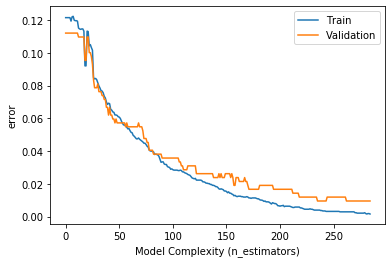

검증 정확도 0.9904534606205251
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       414
           1       0.67      0.40      0.50         5

    accuracy                           0.99       419
   macro avg       0.83      0.70      0.75       419
weighted avg       0.99      0.99      0.99       419

ROC-AUC: 0.8772946859903381


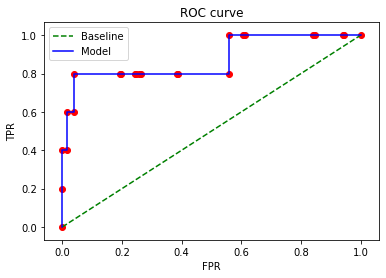

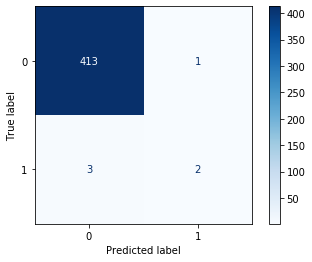

In [61]:
summ_result(model,x_val_enc,y_val)

In [62]:
x_train_over, y_train_over = SMOTE().fit_resample(
    x_train_enc, y_train
)

watchlist_over = [(x_train_over, y_train_over),(x_val_enc, y_val)]

In [63]:
model.fit(
    x_train_over, y_train_over,
    eval_set = watchlist_over,
    early_stopping_rounds=50,
)

[0]	validation_0-error:0.338129	validation_1-error:0.646778
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 50 rounds.
[1]	validation_0-error:0.326297	validation_1-error:0.632458
[2]	validation_0-error:0.338129	validation_1-error:0.646778
[3]	validation_0-error:0.338129	validation_1-error:0.646778
[4]	validation_0-error:0.35238	validation_1-error:0.668258
[5]	validation_0-error:0.351573	validation_1-error:0.663485
[6]	validation_0-error:0.352245	validation_1-error:0.668258
[7]	validation_0-error:0.351707	validation_1-error:0.663485
[8]	validation_0-error:0.351707	validation_1-error:0.663485
[9]	validation_0-error:0.351707	validation_1-error:0.663485
[10]	validation_0-error:0.338397	validation_1-error:0.646778
[11]	validation_0-error:0.345254	validation_1-error:0.656325
[12]	validation_0-error:0.336515	validation_1-error:0.646778
[13]	validation_0-error:0.335171	validation_1-error:0.642

XGBClassifier(n_estimators=99999999999999, n_jobs=-1, scale_pos_weight=82.8)

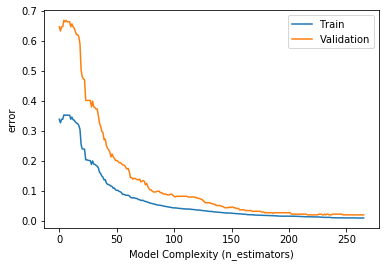

검증 정확도 0.9809069212410502
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       414
           1       0.36      0.80      0.50         5

    accuracy                           0.98       419
   macro avg       0.68      0.89      0.75       419
weighted avg       0.99      0.98      0.98       419

ROC-AUC: 0.942512077294686


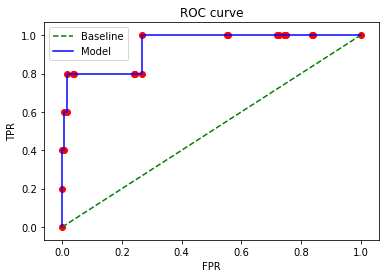

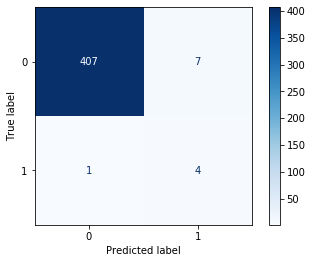

In [64]:
summ_result(model,x_val_enc,y_val)

In [65]:
x_train_smoteen, y_train_smoteen = SMOTEENN().fit_resample(
    x_train_enc,y_train
)

model = XGBClassifier(
    n_estimators = 99999999999999,
    n_jobs=-1,
    scale_pos_weight=(y_train_smoteen == 0).sum() / (y_train_smoteen == 1).sum(),
)

In [66]:
watchlist_sm = [(x_train_smoteen,y_train_smoteen),(x_val_enc,y_val)]

model.fit(
    x_train_smoteen,
    y_train_smoteen,
    eval_set=watchlist_sm,
    early_stopping_rounds=50
)

[0]	validation_0-error:0.062258	validation_1-error:0.095465
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 50 rounds.
[1]	validation_0-error:0.062258	validation_1-error:0.095465
[2]	validation_0-error:0.062258	validation_1-error:0.095465
[3]	validation_0-error:0.035616	validation_1-error:0.097852
[4]	validation_0-error:0.033821	validation_1-error:0.090692
[5]	validation_0-error:0.033131	validation_1-error:0.090692
[6]	validation_0-error:0.033131	validation_1-error:0.090692
[7]	validation_0-error:0.033683	validation_1-error:0.090692
[8]	validation_0-error:0.032993	validation_1-error:0.090692
[9]	validation_0-error:0.033131	validation_1-error:0.090692
[10]	validation_0-error:0.032993	validation_1-error:0.090692
[11]	validation_0-error:0.032993	validation_1-error:0.090692
[12]	validation_0-error:0.030232	validation_1-error:0.093079
[13]	validation_0-error:0.02968	validation_1-error:0.093

XGBClassifier(n_estimators=99999999999999, n_jobs=-1,
              scale_pos_weight=0.9494079655543596)

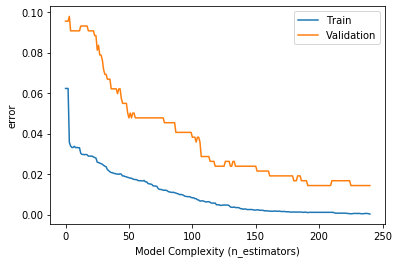

검증 정확도 0.9856801909307876
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       414
           1       0.44      0.80      0.57         5

    accuracy                           0.99       419
   macro avg       0.72      0.89      0.78       419
weighted avg       0.99      0.99      0.99       419

ROC-AUC: 0.9666666666666667


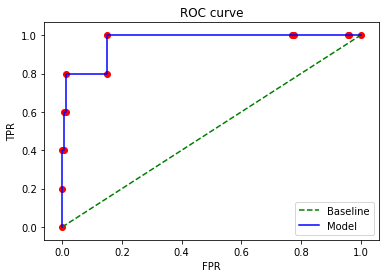

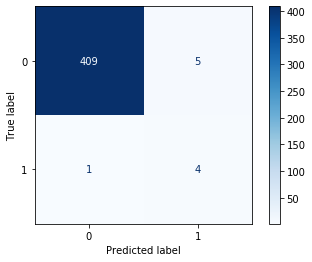

In [67]:
summ_result(model,x_val_enc,y_val)

recall 이 가장 높고, 그외 예측 성능또한 가장 좋은SMOTEEN 기법 사용

In [68]:
pipe_tree = make_pipeline(
    #OrdinalEncoder(cols=cat_feature),
    DecisionTreeClassifier(
        
        #scale_pos_weight=(y_val == 0).sum() / (y_val == 1).sum()
    )
)

pipe_random = make_pipeline(
    #OrdinalEncoder(cols=cat_feature),
    RandomForestClassifier(
        
        #scale_pos_weight=(y_val == 0).sum() / (y_val == 1).sum()
    )
)

pipe_boost = make_pipeline(
    #OrdinalEncoder(cols=cat_feature),
    XGBClassifier(
        #eval_metrics='recall',
        n_jobs=-1,
        #scale_pos_weight=(y_val == 0).sum() / (y_val == 1).sum()
    )
)

In [69]:
pipe_tree.fit(x_train_smoteen,y_train_smoteen)
pipe_random.fit(x_train_smoteen,y_train_smoteen)
pipe_boost.fit(x_train_smoteen,y_train_smoteen)

Pipeline(steps=[('xgbclassifier', XGBClassifier(n_jobs=-1))])

In [70]:
y_tree=pipe_tree.predict(x_val_enc)
y_random=pipe_random.predict(x_val_enc)
y_boost=pipe_boost.predict(x_val_enc)

print('Decision Tree 정확도: ', classification_report(y_val,y_tree))
print('Random Forest 정확도: ', classification_report(y_val,y_random))
print('XGBoost 정확도: ', classification_report(y_val,y_boost))

Decision Tree 정확도:                precision    recall  f1-score   support

           0       0.99      0.99      0.99       414
           1       0.25      0.40      0.31         5

    accuracy                           0.98       419
   macro avg       0.62      0.69      0.65       419
weighted avg       0.98      0.98      0.98       419

Random Forest 정확도:                precision    recall  f1-score   support

           0       0.99      1.00      1.00       414
           1       1.00      0.40      0.57         5

    accuracy                           0.99       419
   macro avg       1.00      0.70      0.78       419
weighted avg       0.99      0.99      0.99       419

XGBoost 정확도:                precision    recall  f1-score   support

           0       1.00      0.97      0.98       414
           1       0.24      0.80      0.36         5

    accuracy                           0.97       419
   macro avg       0.62      0.88      0.67       419
weighted avg       0

In [71]:
params = {
    "xgbclassifier__max_depth": hp.quniform('max_depth', 2,20,1),
    "xgbclassifier__min_child_weight": hp.quniform("min_child_weight", 2,20,1),
    "xgbclassifier__colsample_bytree": hp.uniform("colsample_bytree", 0.1,1.0),
    "xgbclassifier__learning_rate": hp.uniform("learning_rate",0.05,0.3),
    "xgbclassifier__subsample": hp.uniform("subsample",0,1),
    #"xgbclassifier__n_estimators": hp.uniform("n_estimators",100,1000)
}

In [72]:
def get_pipe(params):
    params['xgbclassifier__max_depth']=int(
        params['xgbclassifier__max_depth']
    )
    params['xgbclassifier__min_child_weight']=int(
        params['xgbclassifier__min_child_weight']
    )
    #params['xgbclassifier__n_estimators']=int(
    #    params['xgbclassifier__n_estimators']
    #)
    pipe = make_pipeline(
        #OrdinalEncoder(cat_feature),
        #SMOTEENN().fit_resample(),
        XGBClassifier(
            scale_pos_weight=(y_val == 0).sum() / (y_val == 1).sum(),
            #n_estimators=200,
            n_jobs=-1
        ))
    pipe = pipe.set_params(**params)
    return pipe

def fit_and_eval(params):
    pipe=get_pipe(params)
    score = cross_val_score(pipe, x_train_smoteen, y_train_smoteen, cv=40, scoring="recall")
    avg_cv_score = np.mean(score)
    
    return {"loss": -avg_cv_score, "status": STATUS_OK}

trials = (Trials())

best_params = fmin( fn=fit_and_eval, trials=trials, space=params, algo=tpe.suggest, max_evals = 40)

100%|██████████| 40/40 [21:52<00:00, 32.82s/it, best loss: -1.0]


In [73]:
trials.best_trial["misc"]["vals"]

{'colsample_bytree': [0.3552710026363026],
 'learning_rate': [0.060754826676306065],
 'max_depth': [16.0],
 'min_child_weight': [9.0],
 'subsample': [0.13191913000979438]}

In [74]:
print("최적 하이퍼파라미터:", trials.best_trial["misc"]["vals"])
print("최적 AUC: ", -trials.best_trial["result"]["loss"])

최적 하이퍼파라미터: {'colsample_bytree': [0.3552710026363026], 'learning_rate': [0.060754826676306065], 'max_depth': [16.0], 'min_child_weight': [9.0], 'subsample': [0.13191913000979438]}
최적 AUC:  1.0


In [75]:
xgbmodel = XGBClassifier(
    colsample_bytree=0.22894911427707437,
    learning_rate=0.1660227491926941,
    max_depth= 14,
    min_child_weight=14,
    n_estimators=999999999999,
    subsample = 0.10456144441354098,
    scale_pos_weight=(y_val == 0).sum() / (y_val == 1).sum()
)



In [76]:
xgbmodel.fit(
    x_train_smoteen,
    y_train_smoteen,
    eval_set=watchlist_sm,
    early_stopping_rounds=50)
print('검증 정확도: ',xgbmodel.score(x_val_enc,y_val))

[0]	validation_0-error:0.228603	validation_1-error:0.472554
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 50 rounds.
[1]	validation_0-error:0.227361	validation_1-error:0.472554
[2]	validation_0-error:0.276919	validation_1-error:0.570406
[3]	validation_0-error:0.239509	validation_1-error:0.51074
[4]	validation_0-error:0.217559	validation_1-error:0.465394
[5]	validation_0-error:0.178355	validation_1-error:0.393795
[6]	validation_0-error:0.150469	validation_1-error:0.322196
[7]	validation_0-error:0.124241	validation_1-error:0.27685
[8]	validation_0-error:0.119271	validation_1-error:0.281623
[9]	validation_0-error:0.135284	validation_1-error:0.317422
[10]	validation_0-error:0.134042	validation_1-error:0.322196
[11]	validation_0-error:0.120237	validation_1-error:0.286396
[12]	validation_0-error:0.127002	validation_1-error:0.303103
[13]	validation_0-error:0.128382	validation_1-error:0.3126

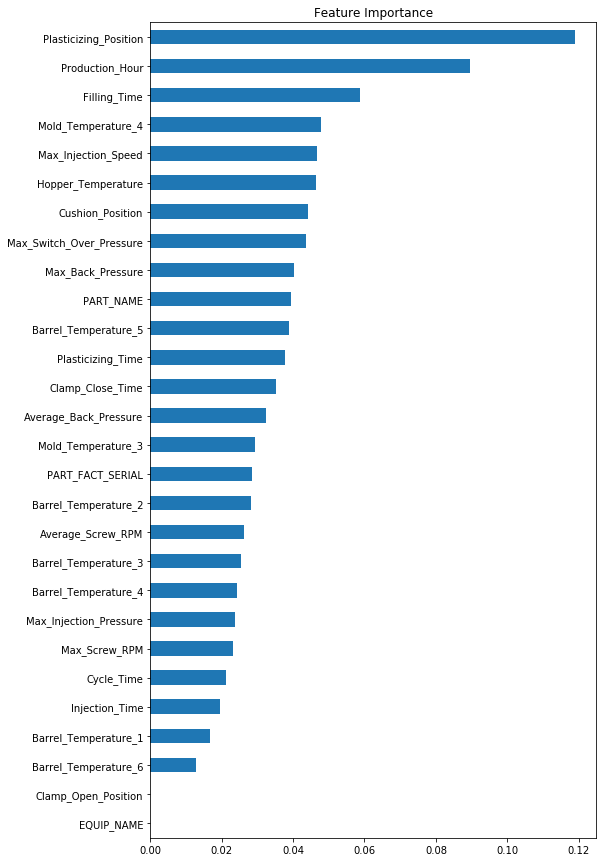

Text(0.5, 1.0, 'Cardinality')

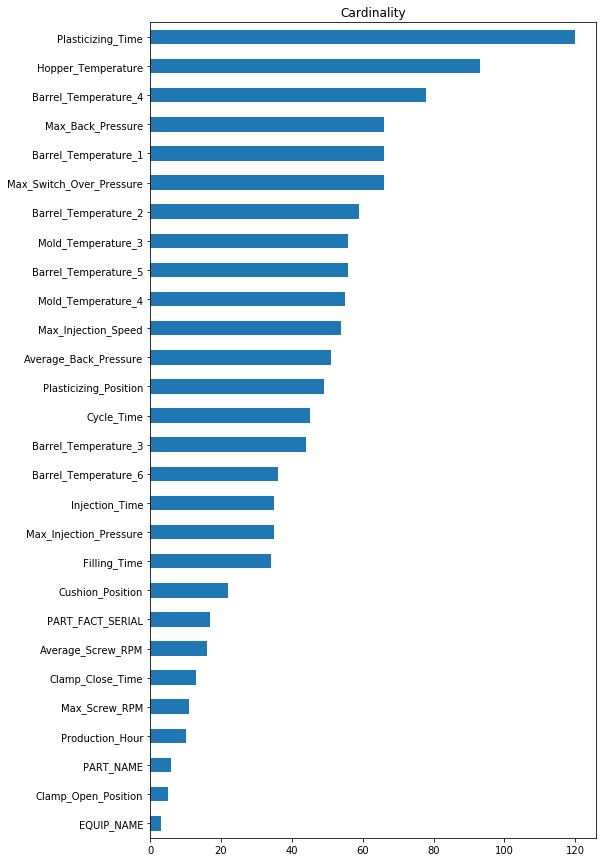

In [77]:
importances = pd.Series(xgbmodel.feature_importances_, x_train.columns)

plt.figure(figsize=(8,15))
importances.sort_values().plot.barh()
plt.title("Feature Importance")
plt.show()

plt.figure(figsize=(8,15))
x_train.nunique().sort_values().plot.barh()
plt.title("Cardinality")


In [78]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    xgbmodel,
    scoring='recall',
    n_iter=30,
    
)

x_test_preprocessed = enc.transform(x_test)
permuter.fit(x_test_preprocessed,y_test)

PermutationImportance(estimator=XGBClassifier(colsample_bytree=0.22894911427707437,
                                              learning_rate=0.1660227491926941,
                                              max_depth=14, min_child_weight=14,
                                              n_estimators=999999999999,
                                              scale_pos_weight=82.8,
                                              subsample=0.10456144441354098),
                      n_iter=30, scoring='recall')

Text(0.5, 1.0, 'Permutation Importance')

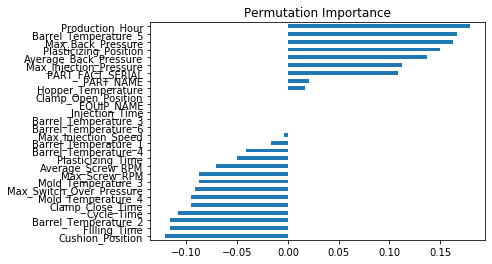

In [79]:
feature_names = x_test.columns.tolist()

pi = pd.Series(permuter.feature_importances_, feature_names).sort_values()
pi.plot.barh()
plt.title("Permutation Importance")


In [80]:
eli5.show_weights(
    permuter,
    top=None,
    feature_names=feature_names
)

Weight,Feature
0.1792 ± 0.2299,Production_Hour
0.1667 ± 0.1344,Barrel_Temperature_5
0.1625 ± 0.1953,Max_Back_Pressure
0.1500 ± 0.1633,Plasticizing_Position
0.1375 ± 0.1865,Average_Back_Pressure
0.1125 ± 0.0750,Max_Injection_Pressure
0.1083 ± 0.0850,PART_FACT_SERIAL
0.0208 ± 0.1455,PART_NAME
0.0167 ± 0.2014,Hopper_Temperature
0 ± 0.0000,Clamp_Open_Position


# 5. PDP


(<Figure size 3000x1900 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7ff151d298d0>,
  'pdp_ax': {'_pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7ff151b8b390>,
   '_count_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7ff151b3b850>}})

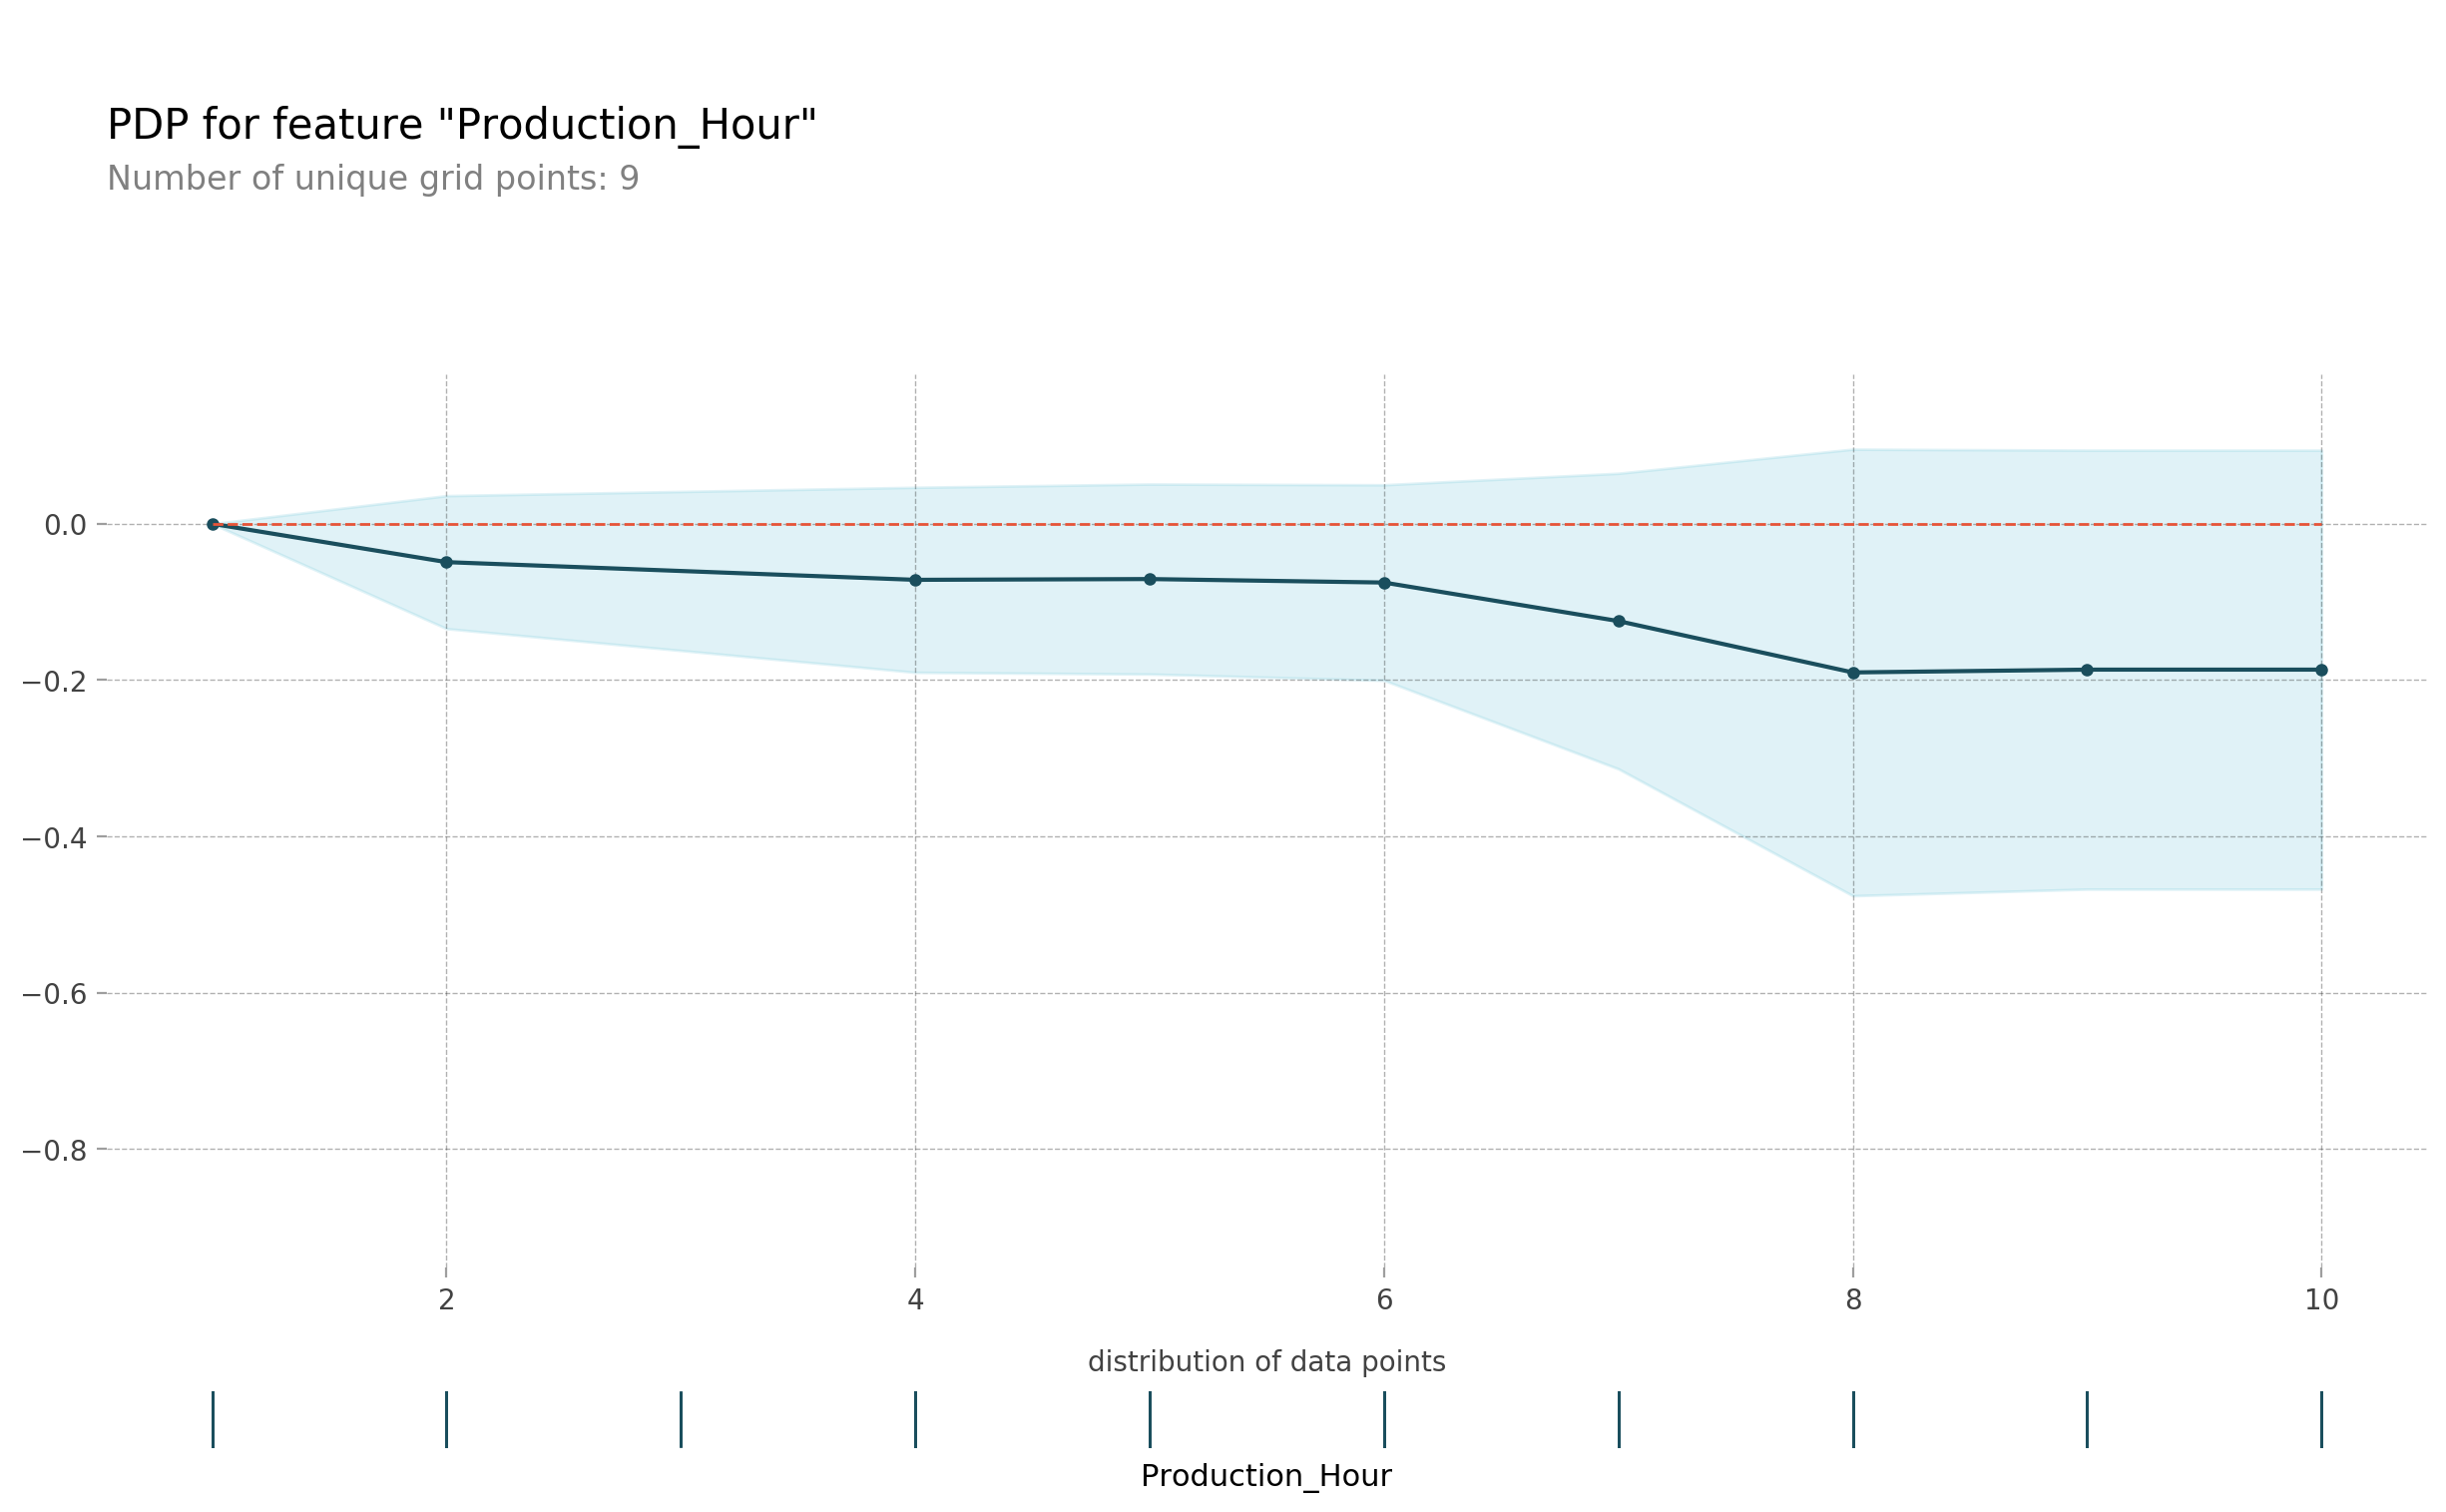

In [81]:
from tqdm import tqdm
plt.rcParams["figure.dpi"]=200
from pdpbox.pdp import pdp_isolate, pdp_plot
target_feature = 'Production_Hour'

isolated = pdp_isolate(
    model=xgbmodel,
    dataset=x_val_enc,
    model_features= x_val.columns,
    feature=target_feature,
    grid_type="percentile",
    num_grid_points=10,
)

pdp_plot(isolated,feature_name=target_feature, frac_to_plot=50,
         plot_pts_dist=True)

In [82]:
data.Production_Hour.unique()

array([ 4,  5,  6,  7,  8, 23,  0,  1,  2,  3])

(<Figure size 3000x1900 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7ff151aea610>,
  'pdp_ax': {'_pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7ff150235390>,
   '_count_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7ff1502638d0>}})

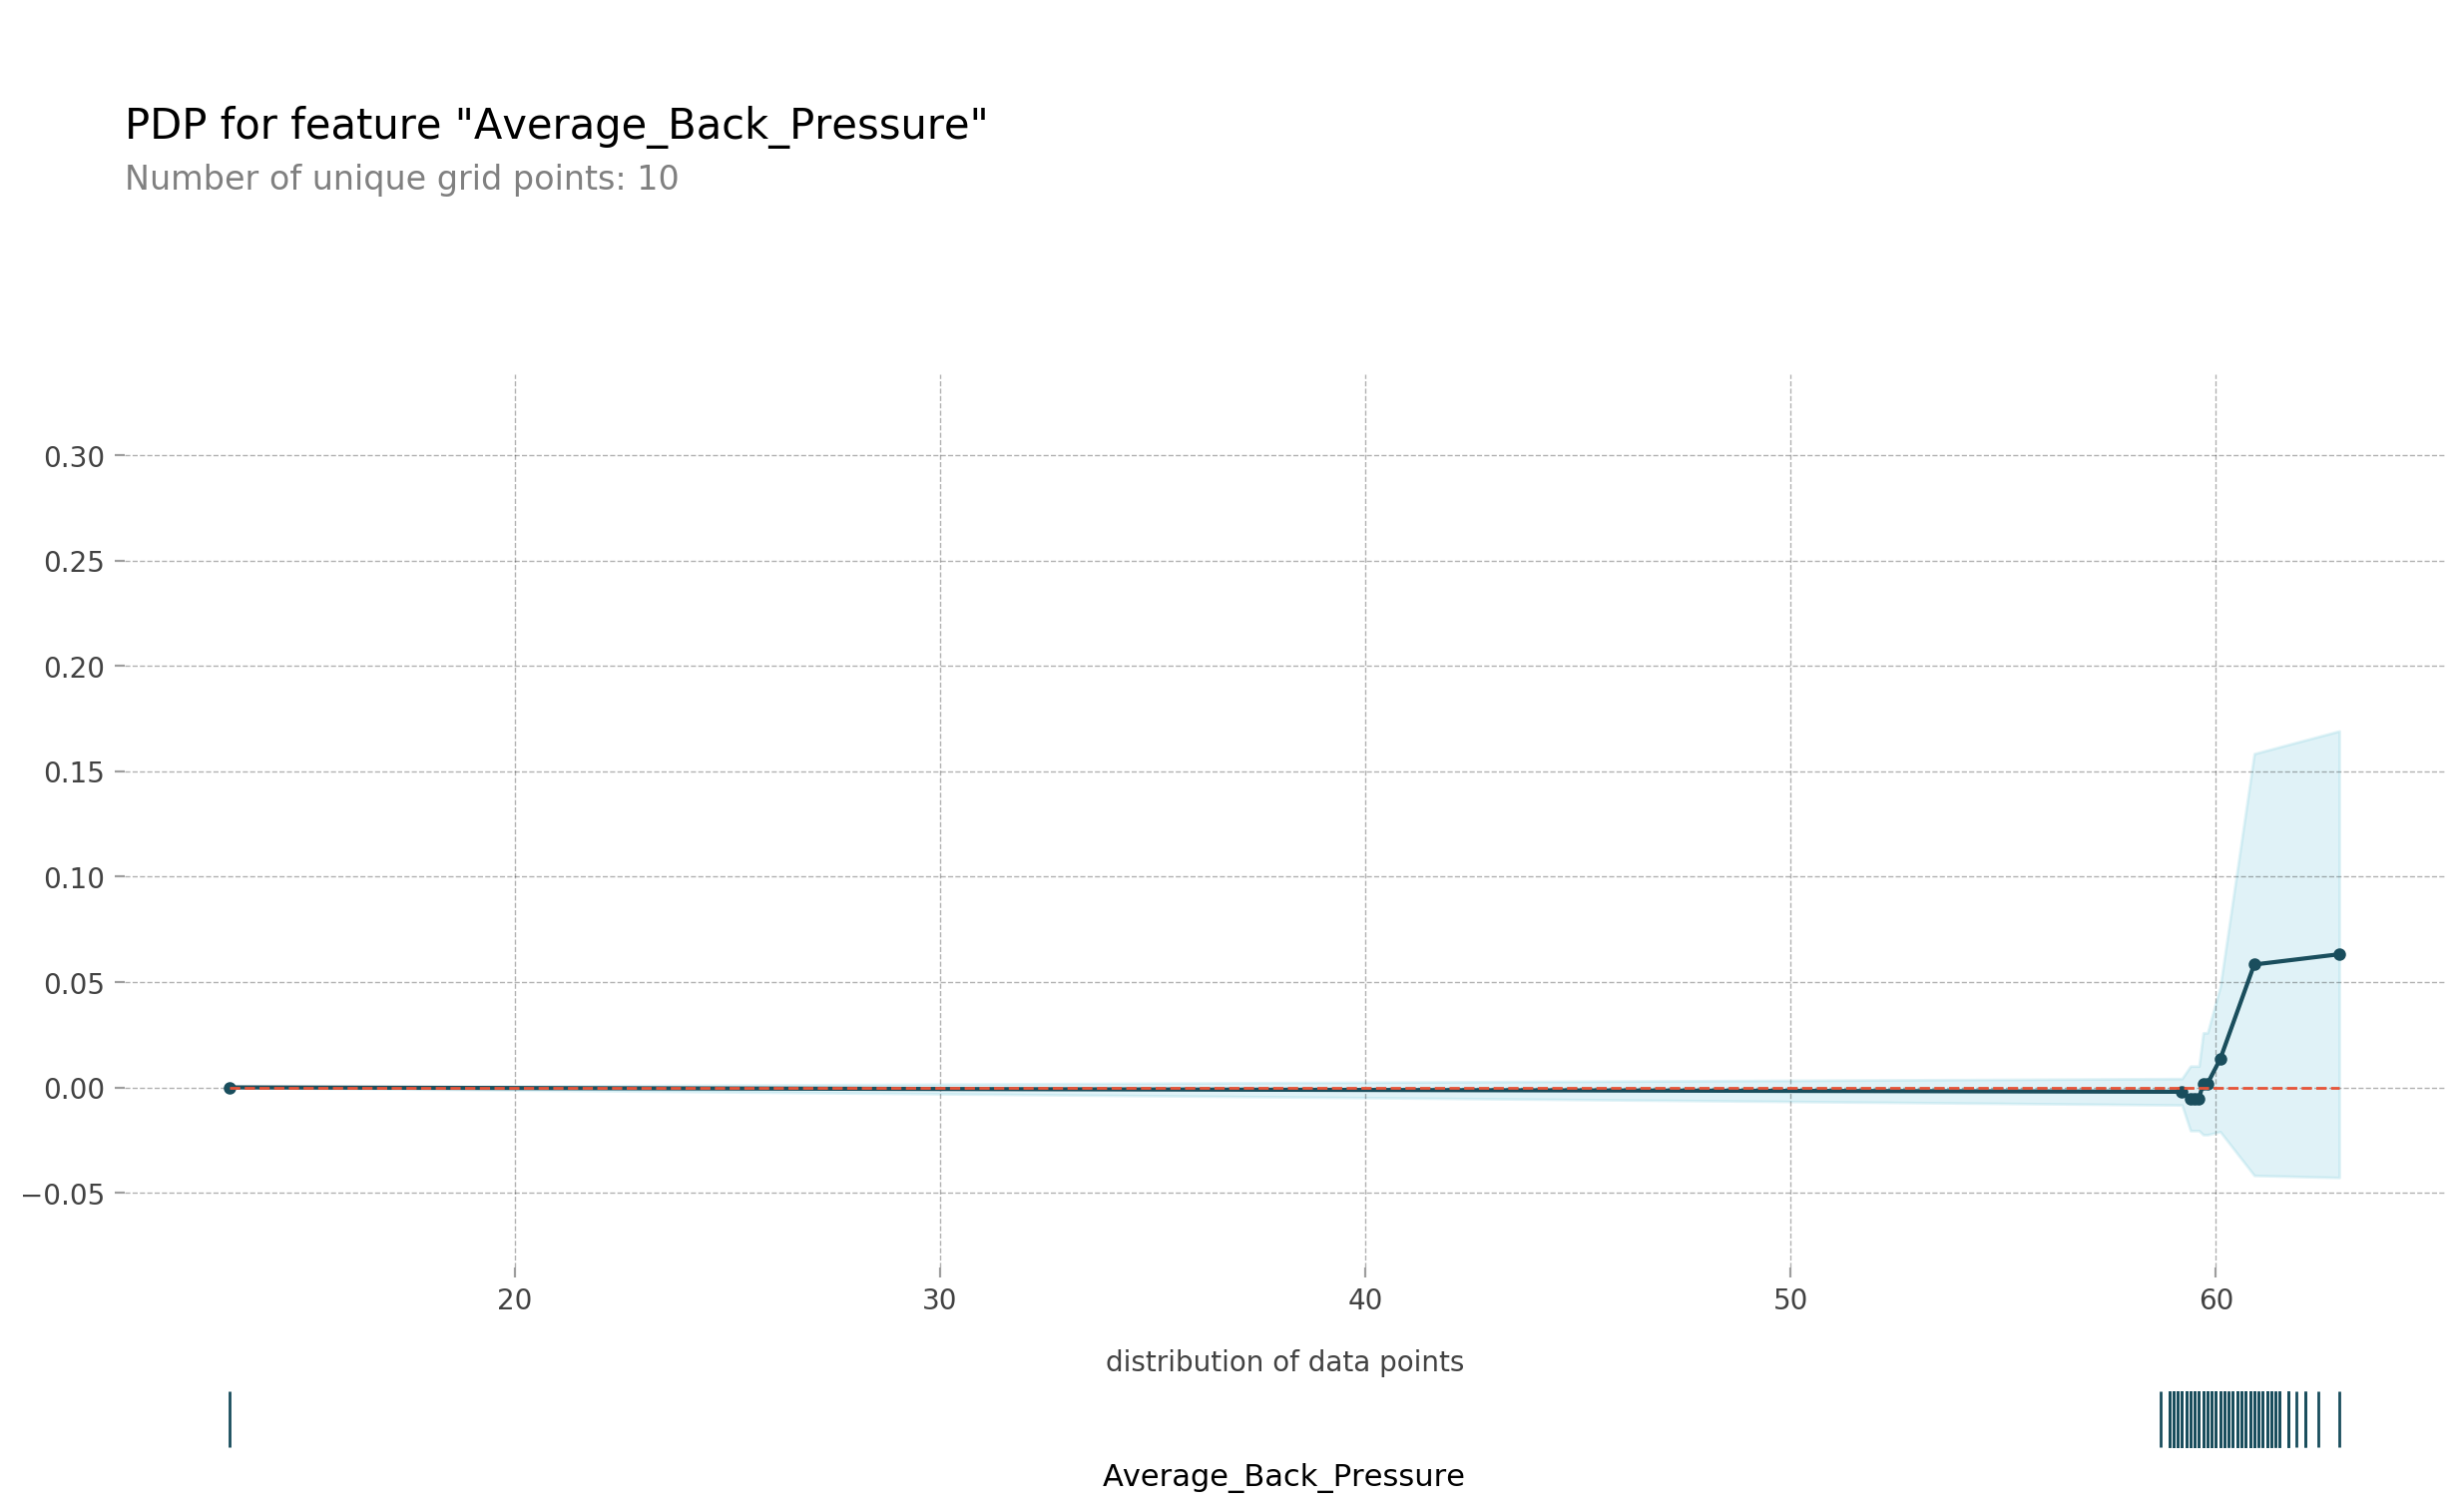

In [83]:
target_feature='Average_Back_Pressure'

isolated = pdp_isolate(
    model=xgbmodel,
    dataset=x_val_enc,
    model_features= x_val.columns,
    feature=target_feature,
    grid_type="percentile",
    num_grid_points=10,
)

pdp_plot(isolated,feature_name=target_feature, frac_to_plot=50,
         plot_pts_dist=True)

(<Figure size 3000x1900 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7ff151ab3cd0>,
  'pdp_ax': {'_pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7ff151a75550>,
   '_count_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7ff150104590>}})

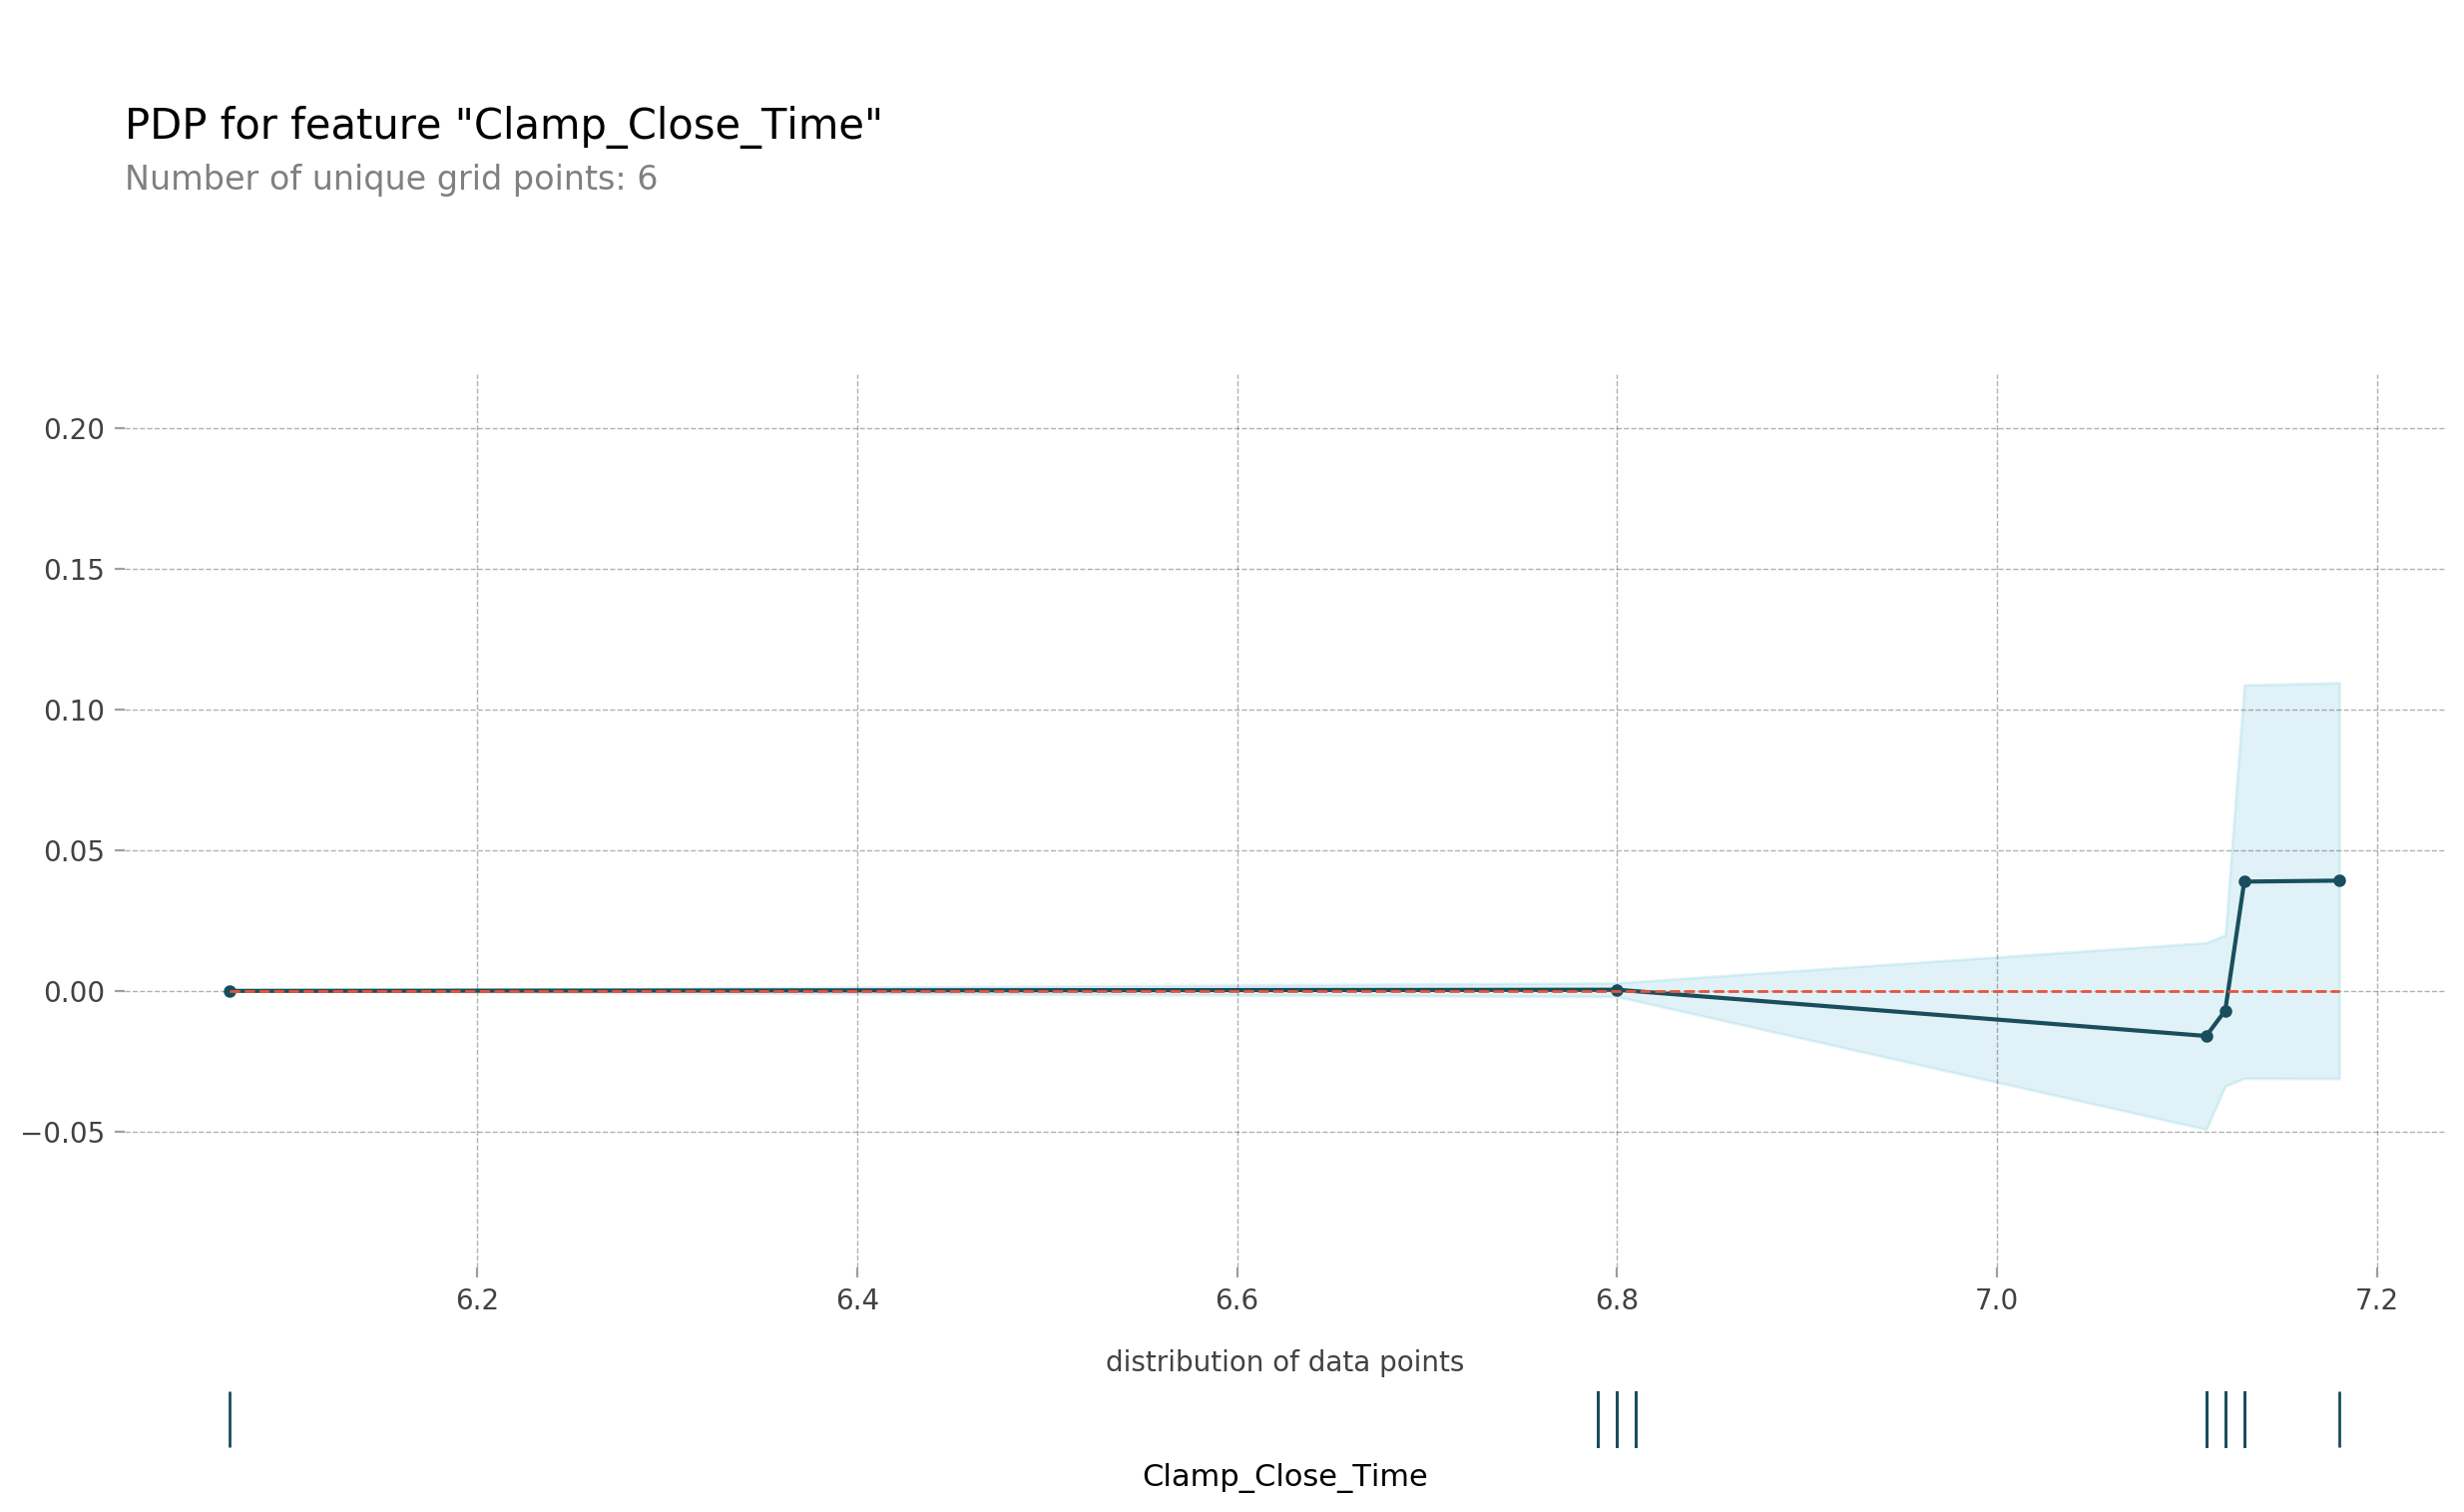

In [84]:

target_feature='Clamp_Close_Time'

isolated = pdp_isolate(
    model=xgbmodel,
    dataset=x_val_enc,
    model_features= x_val.columns,
    feature=target_feature,
    grid_type="percentile",
    num_grid_points=10,
)

pdp_plot(isolated,feature_name=target_feature, frac_to_plot=50,
         plot_pts_dist=True)

(<Figure size 3000x1900 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7ff150041990>,
  'pdp_ax': {'_pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7ff150065f90>,
   '_count_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7ff150026490>}})

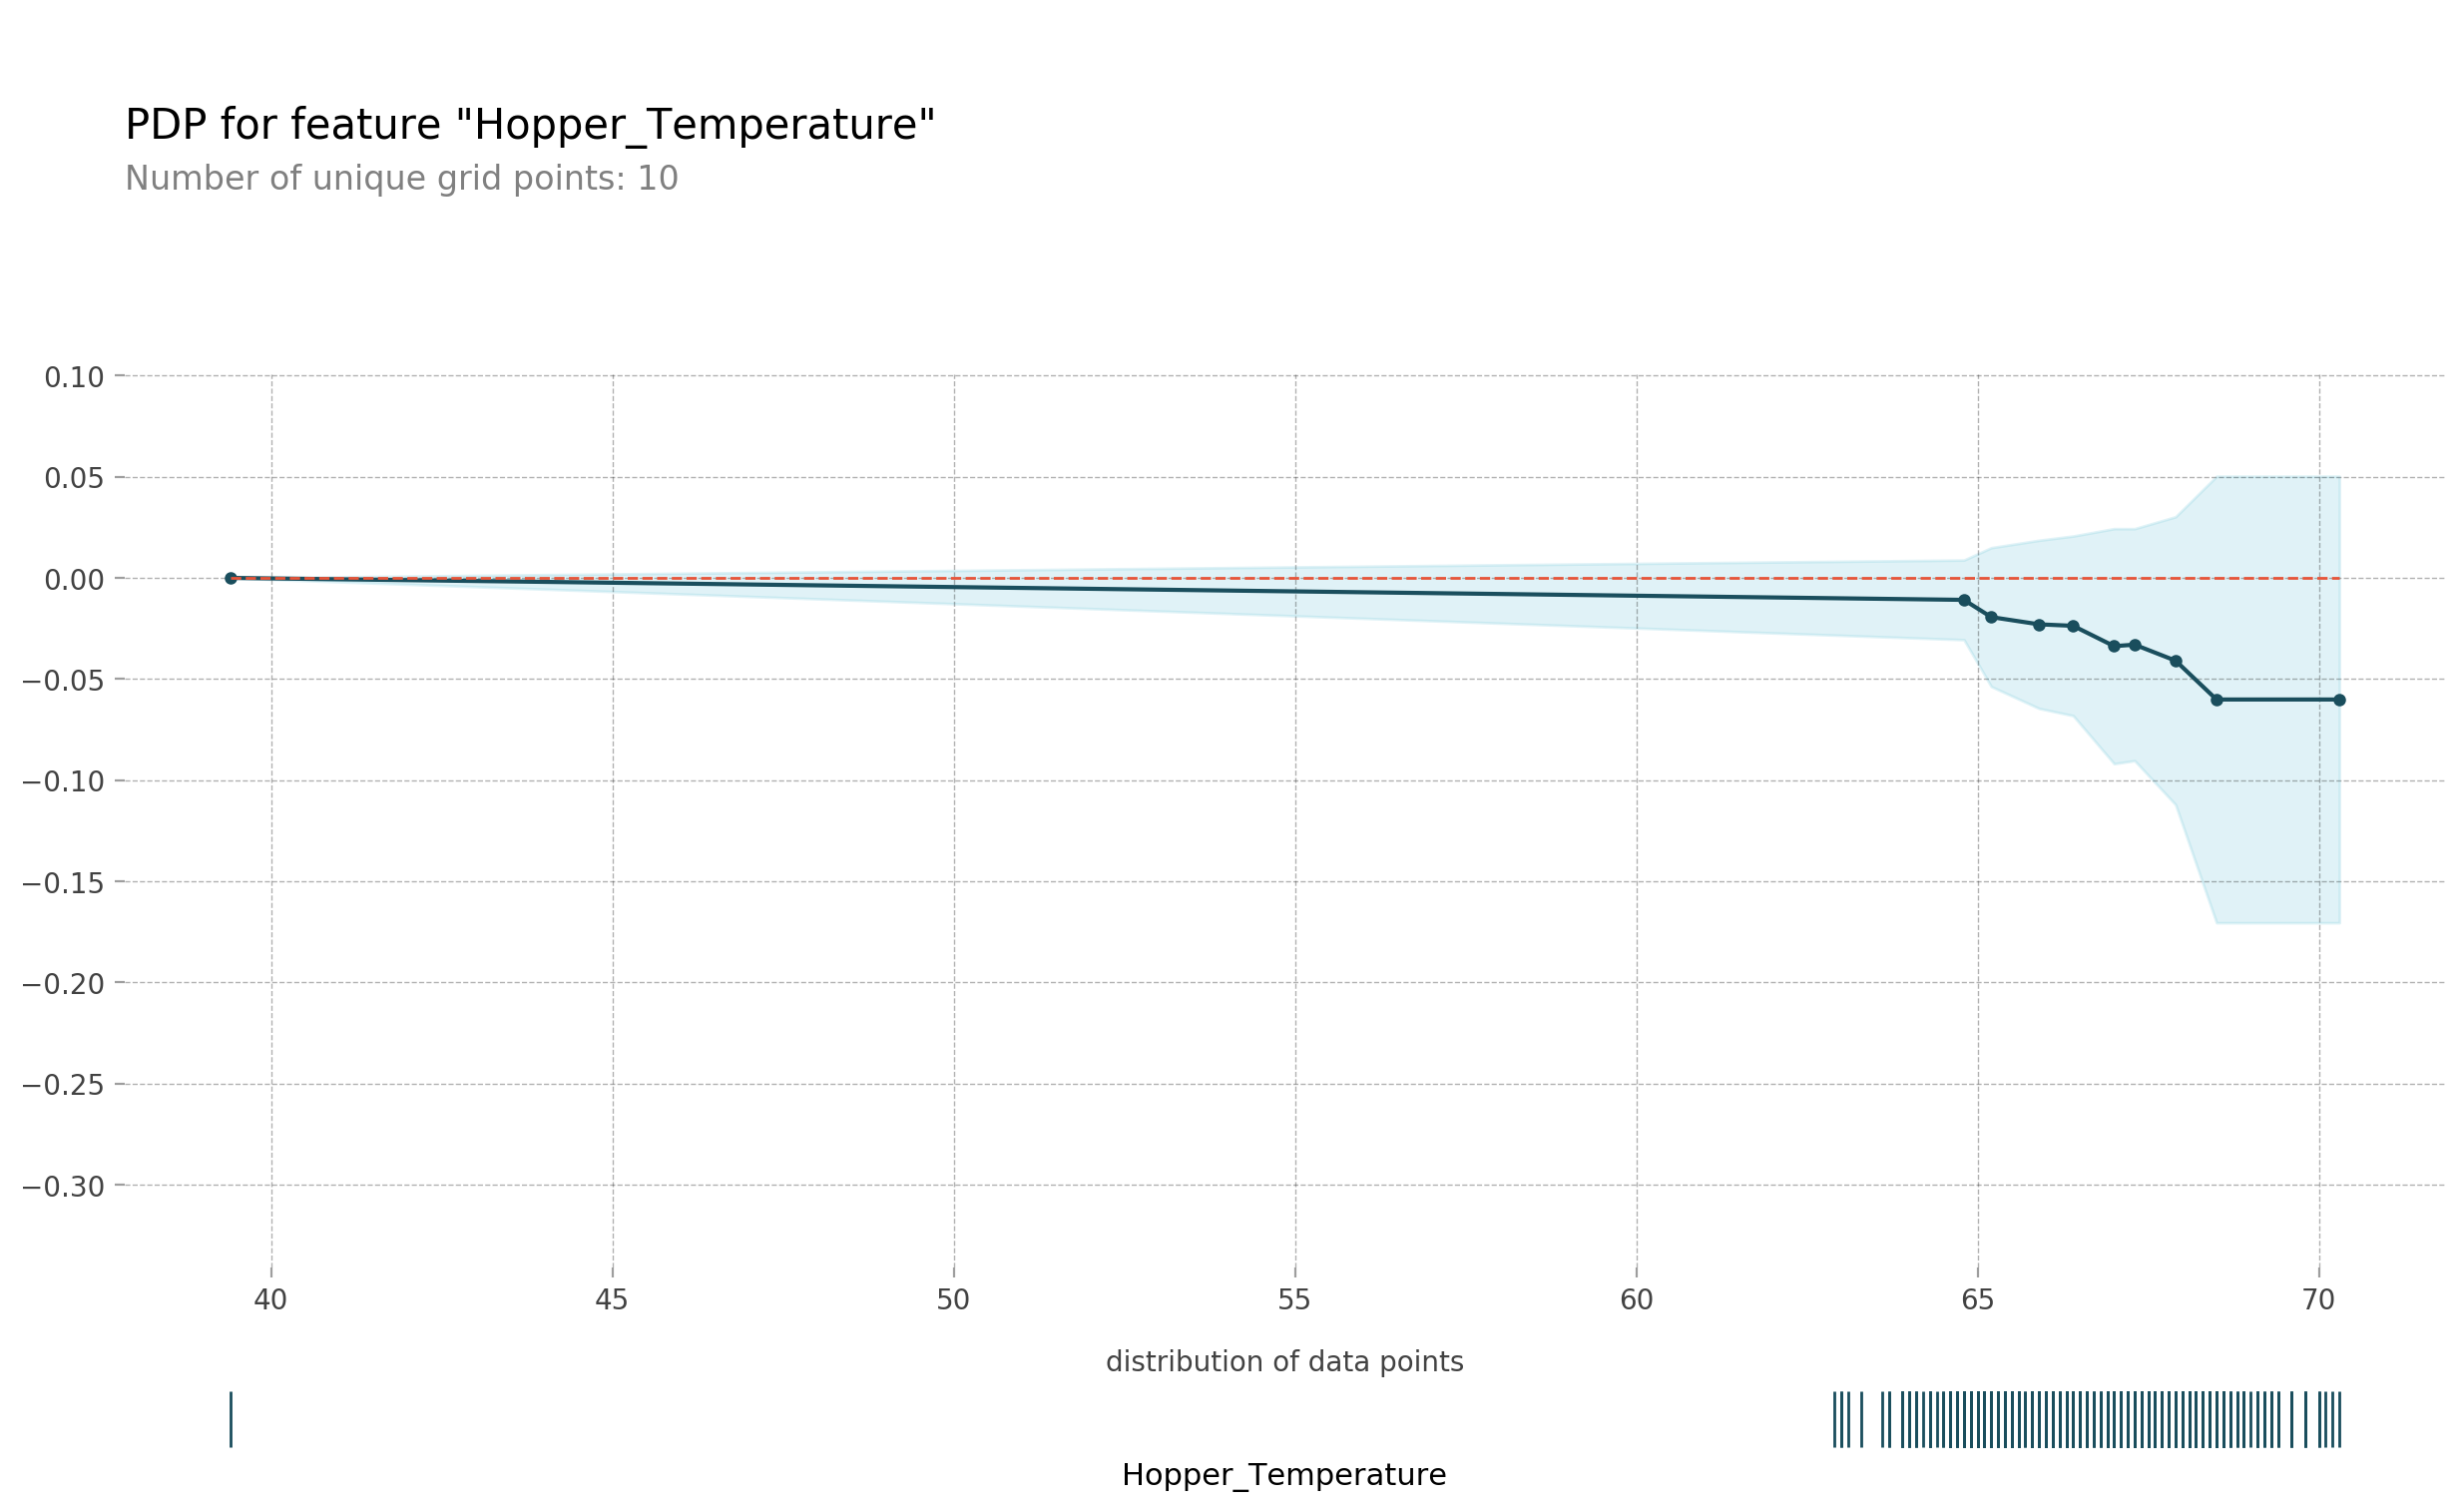

In [85]:
target_feature='Hopper_Temperature'

isolated = pdp_isolate(
    model=xgbmodel,
    dataset=x_val_enc,
    model_features= x_val.columns,
    feature=target_feature,
    grid_type="percentile",
    num_grid_points=10,
)

pdp_plot(isolated,feature_name=target_feature, frac_to_plot=50,
         plot_pts_dist=True)

(<Figure size 3000x1900 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7ff14ff64490>,
  'pdp_ax': {'_pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7ff14ff1de90>,
   '_count_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7ff14fedd390>}})

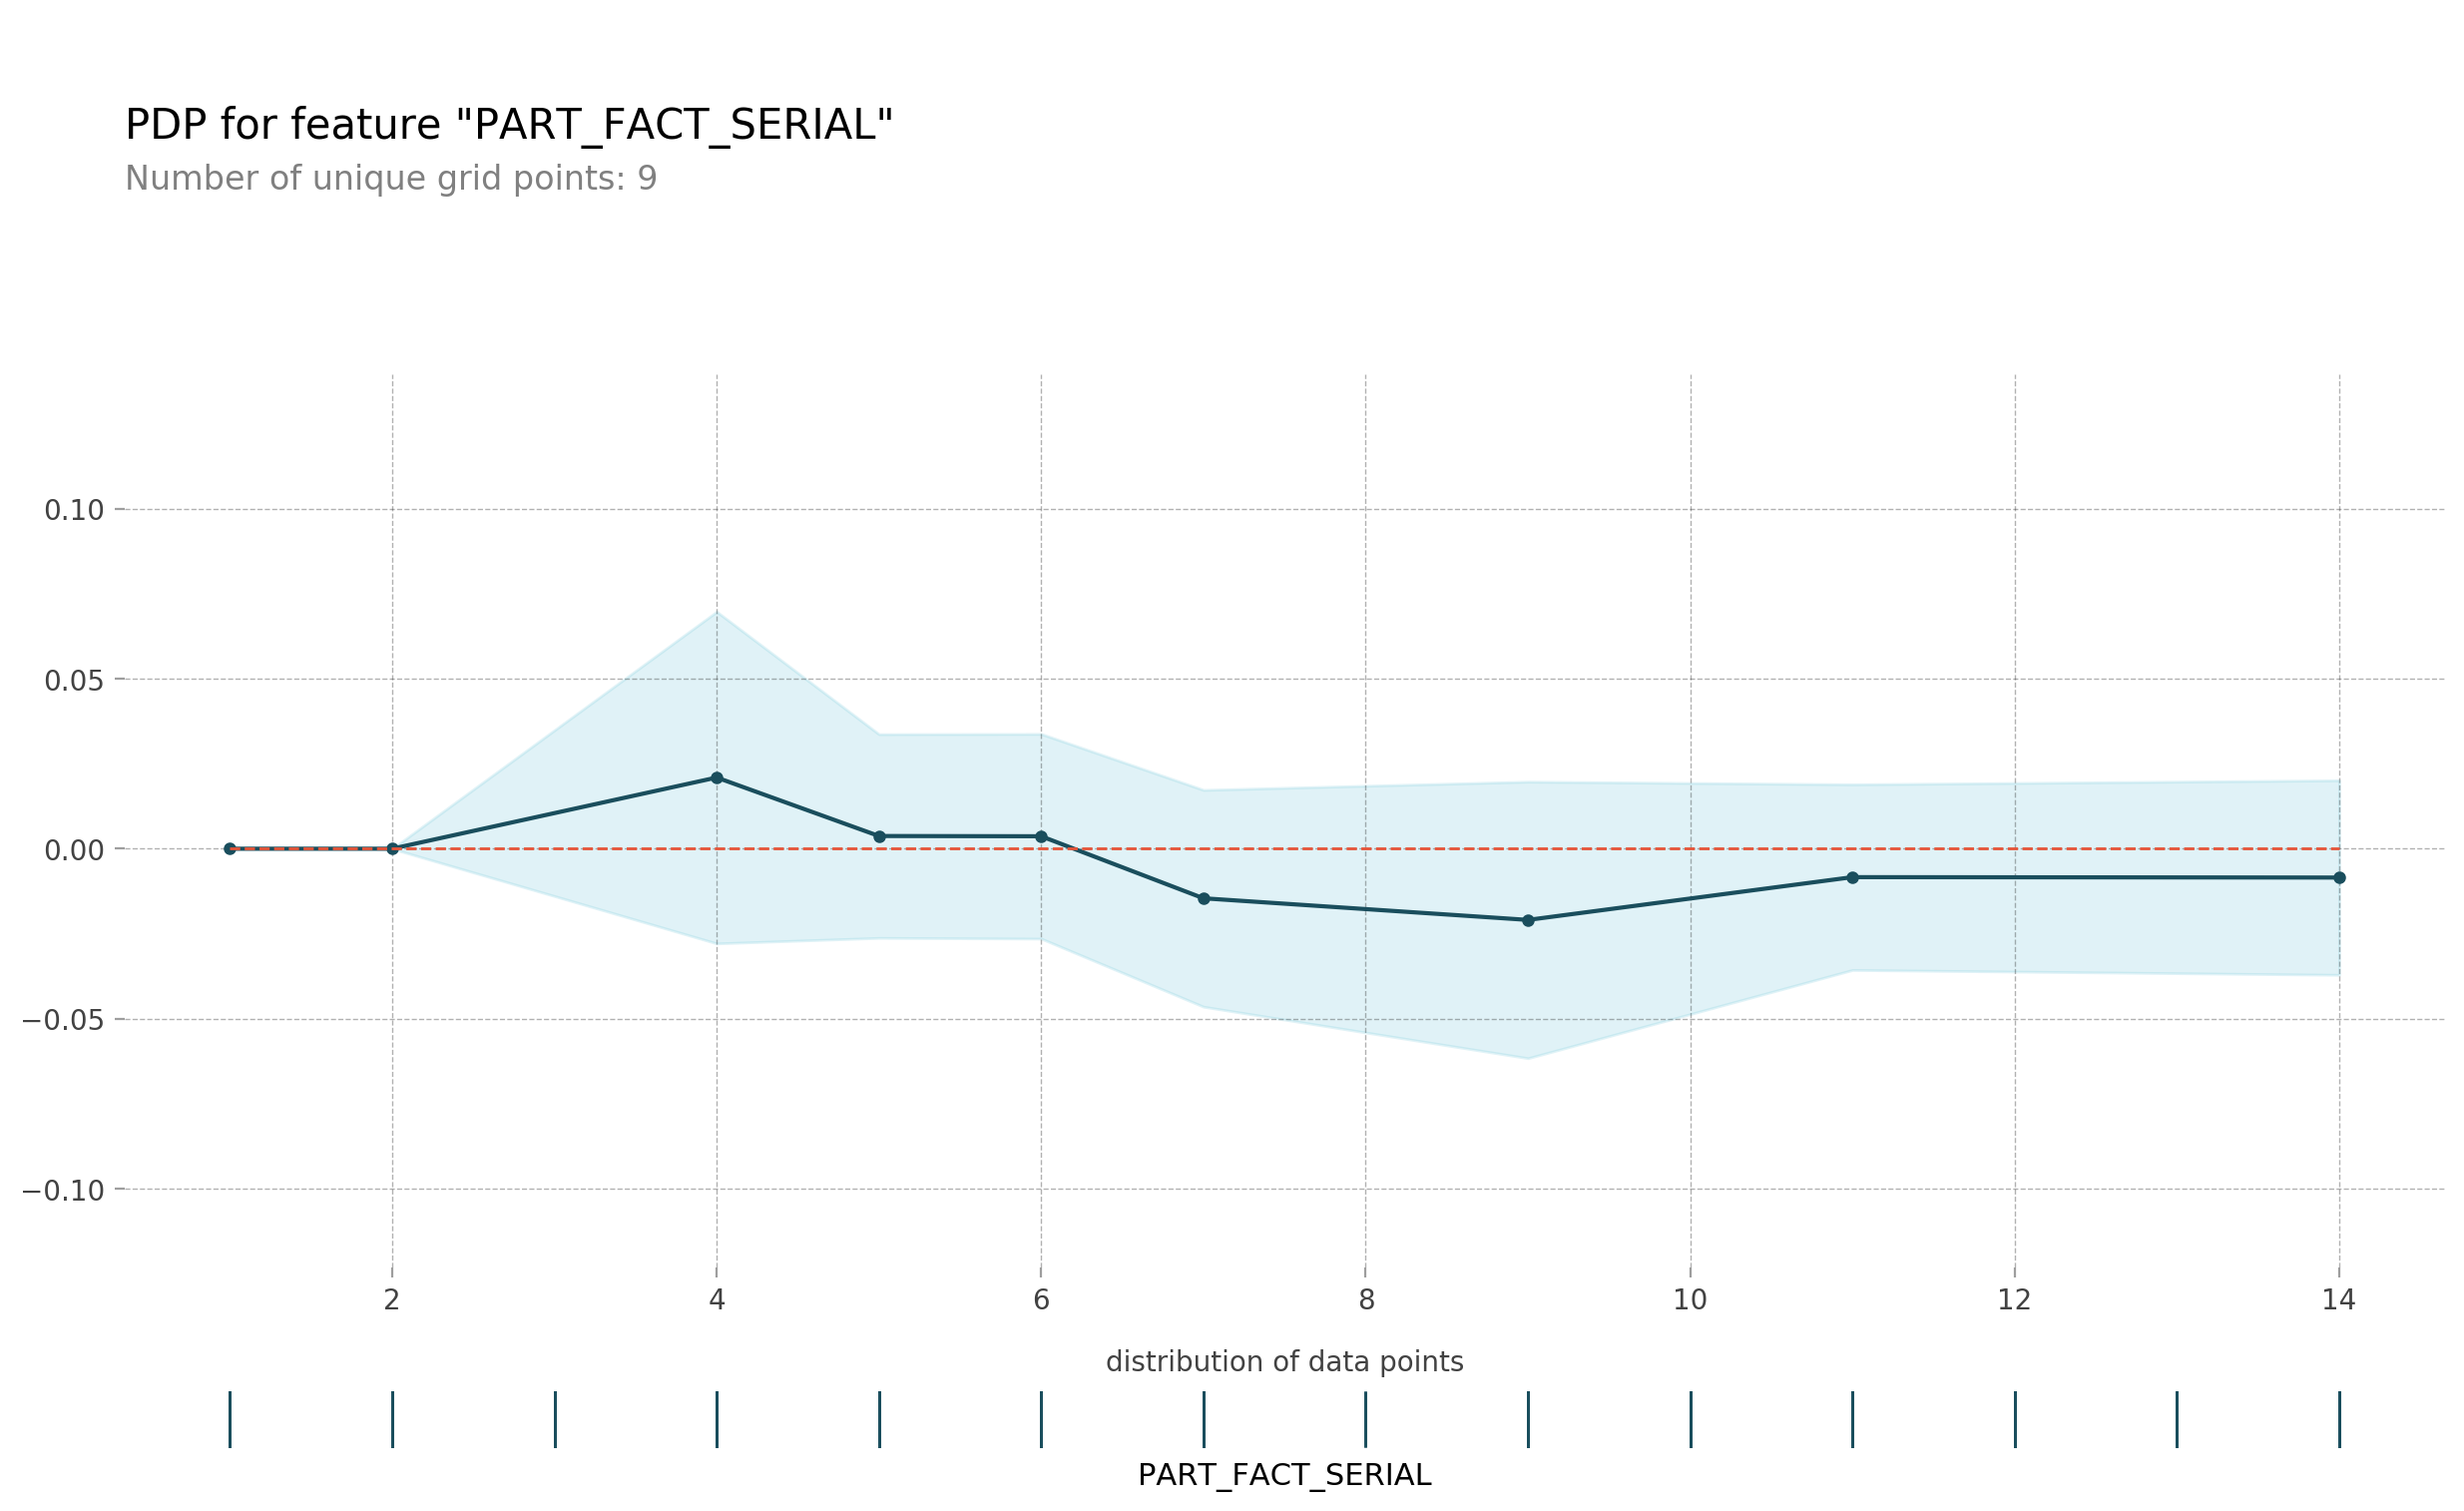

In [86]:
target_feature='PART_FACT_SERIAL'

isolated = pdp_isolate(
    model=xgbmodel,
    dataset=x_val_enc,
    model_features= x_val.columns,
    feature=target_feature,
    grid_type="percentile",
    num_grid_points=10,
)

pdp_plot(isolated,feature_name=target_feature, frac_to_plot=50,
         plot_pts_dist=True)

(<Figure size 3000x1900 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7ff14ff3b850>,
  'pdp_ax': {'_pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7ff14fdbef10>,
   '_count_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7ff14fd81410>}})

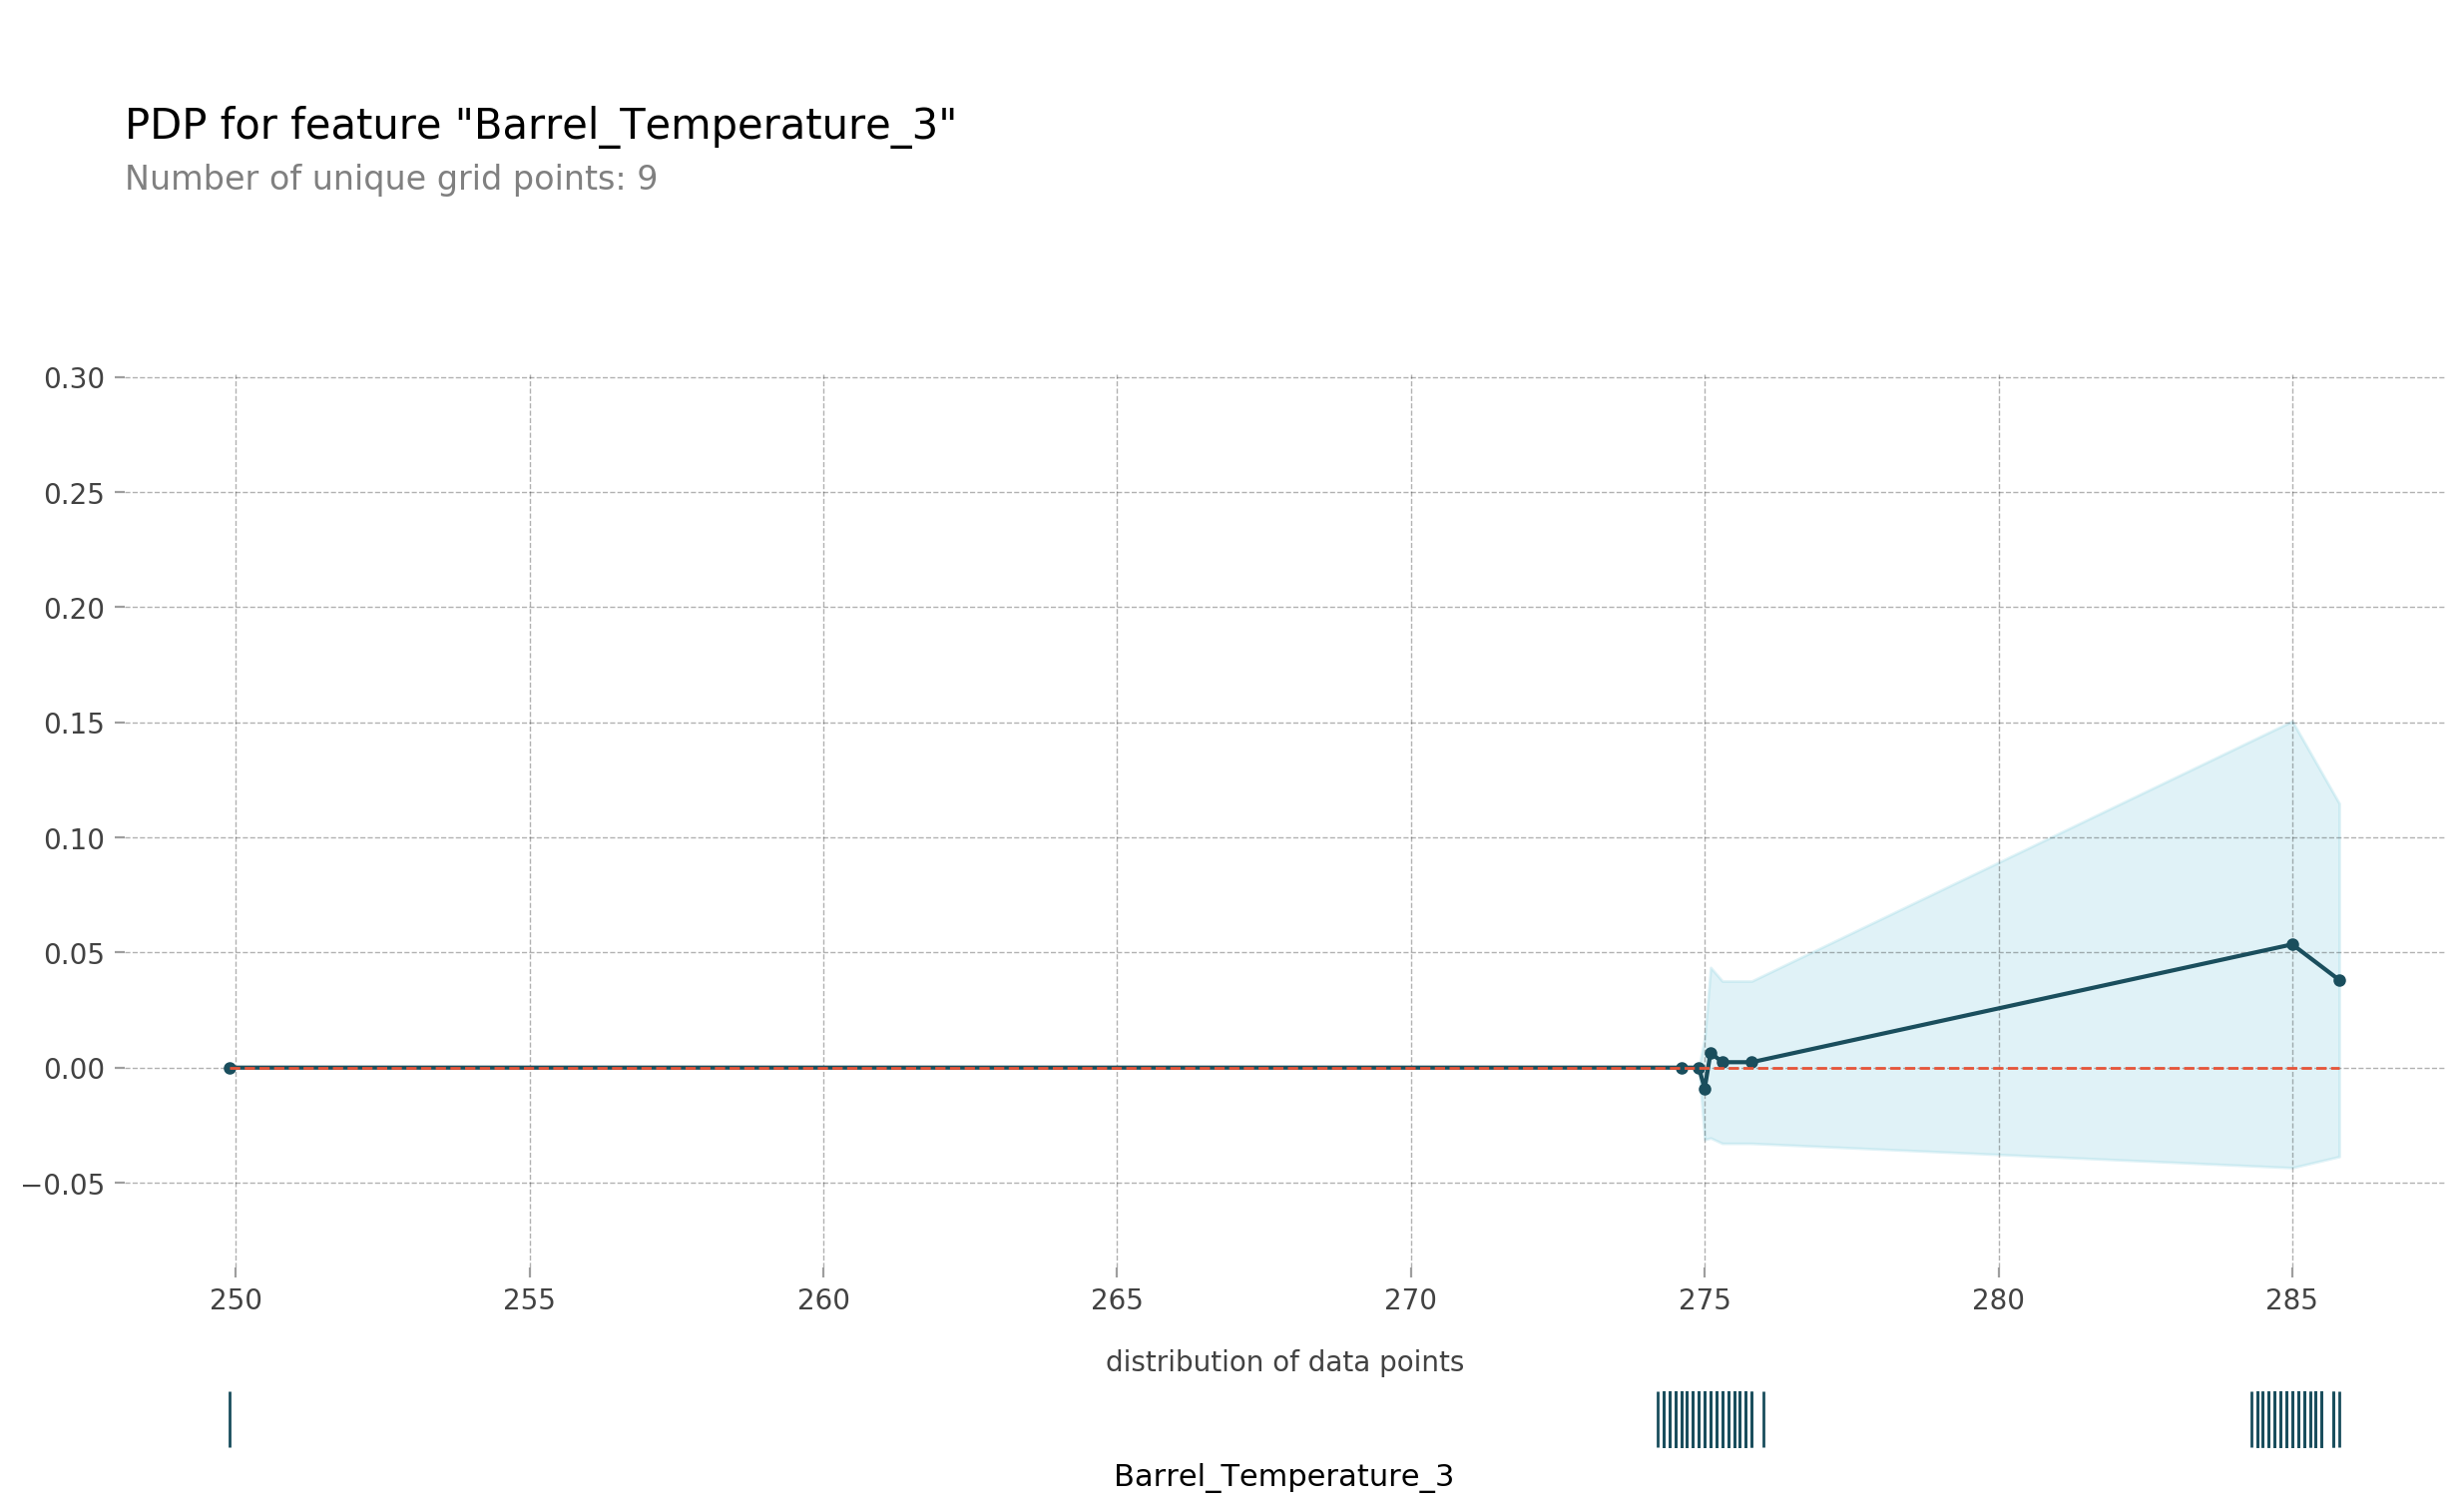

In [87]:
target_feature='Barrel_Temperature_3'

isolated = pdp_isolate(
    model=xgbmodel,
    dataset=x_val_enc,
    model_features= x_val.columns,
    feature=target_feature,
    grid_type="percentile",
    num_grid_points=10,
)

pdp_plot(isolated,feature_name=target_feature, frac_to_plot=50,
         plot_pts_dist=True)

In [88]:
import graphviz
from sklearn.tree import export_graphviz

model_dt = xgbmodel
enc_columns = x_val_enc.columns

dot_data = export_graphviz(model_dt,
                           max_depth=14,
                           feature_names=enc_columns,
                           class_names=['Fine','Defect'],
                           filled=True,
                           proportion=True)

display(graphviz.Source(dot_data))

AttributeError: ignored

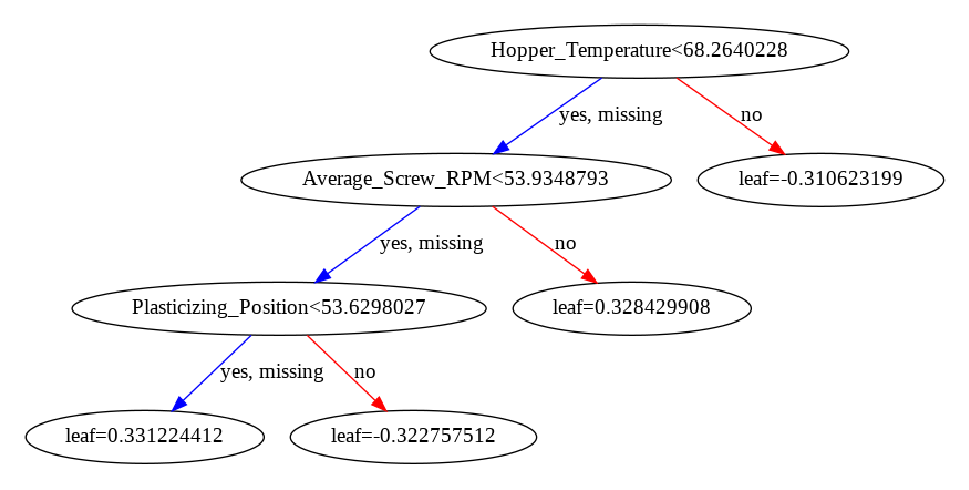

In [89]:
from xgboost import plot_tree
plot_tree(xgbmodel)
plt.show()

In [90]:
import xgboost
xgboost.to_graphviz(xgbmodel, num_tress=0, size="10,10")

TypeError: ignored

In [91]:
x_test_enc = enc.transform(x_test)
y_pred=xgbmodel.predict(x_test_enc)

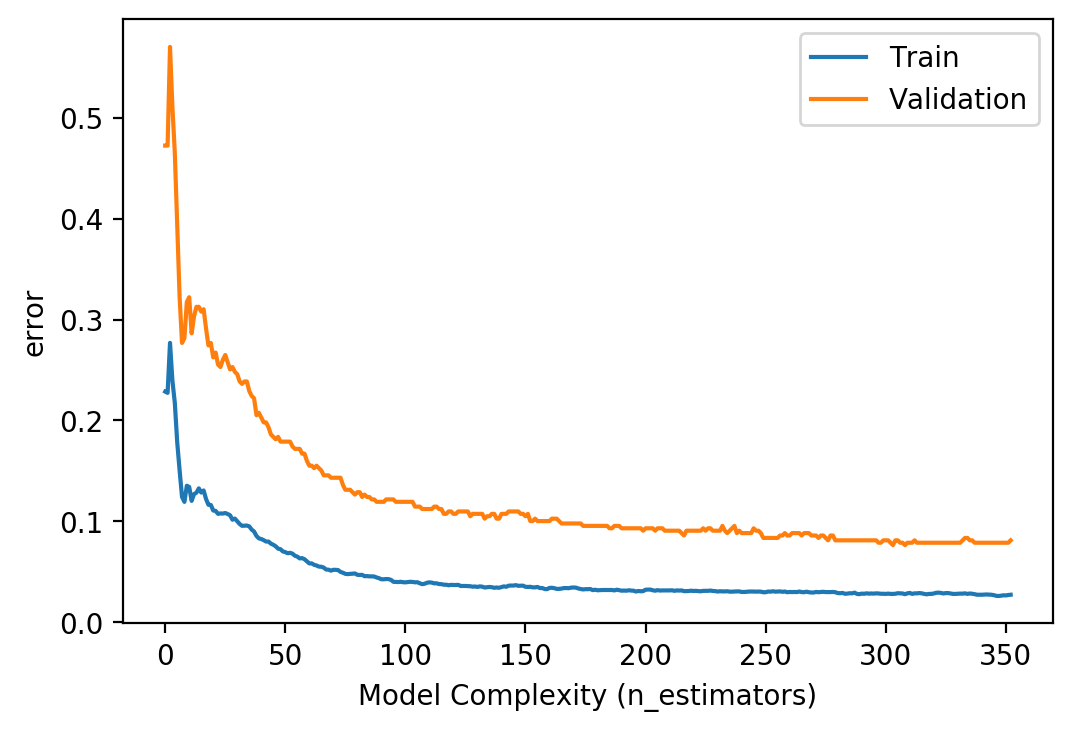

검증 정확도 0.9016236867239733
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1039
           1       0.06      0.88      0.12         8

    accuracy                           0.90      1047
   macro avg       0.53      0.89      0.53      1047
weighted avg       0.99      0.90      0.94      1047

ROC-AUC: 0.940567853705486


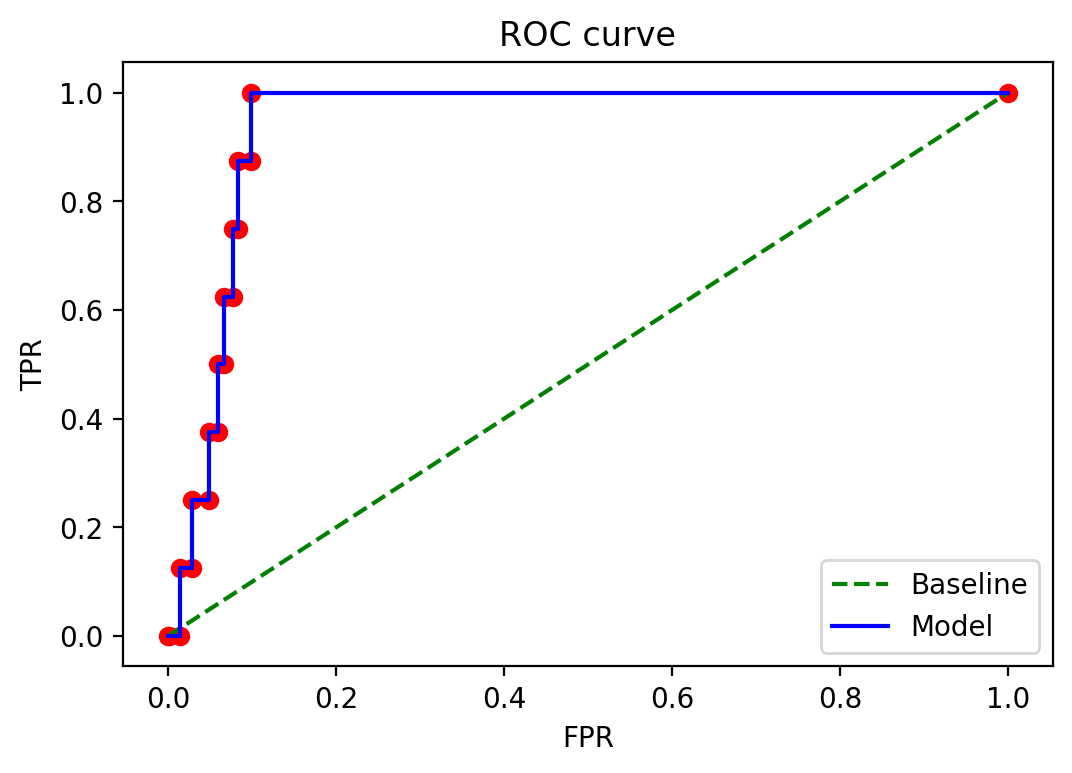

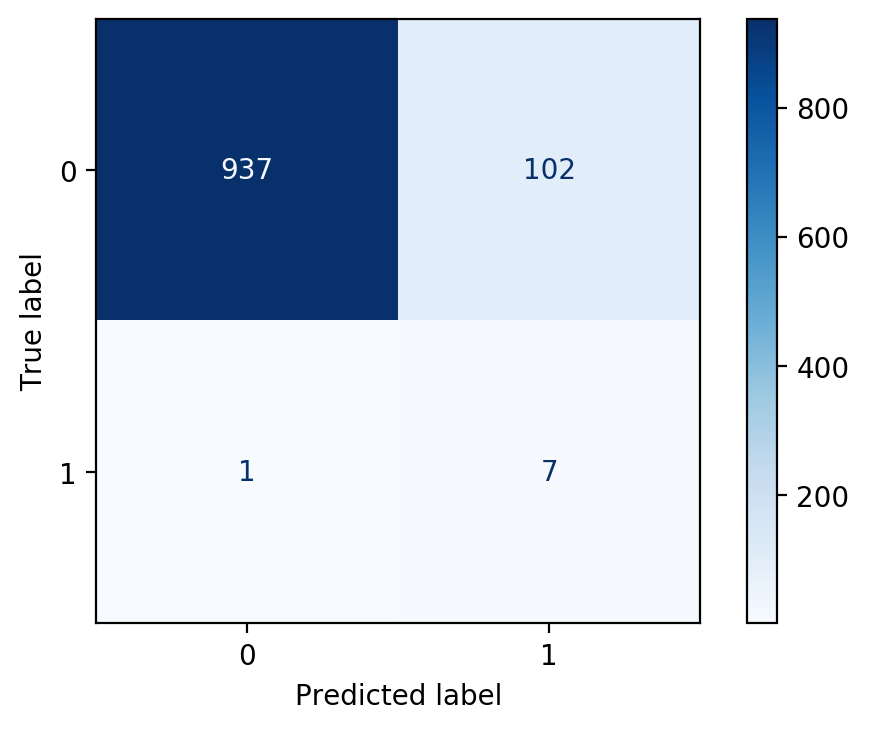

In [92]:
summ_result(xgbmodel, x_test_enc,y_test)

In [100]:
unlabeled_set = pd.read_csv('unlabeled_data.csv')
print(unlabeled_set.nunique(),data.nunique())
unlabeled_set['TimeStamp']= unlabeled_set.TimeStamp.apply(pd.to_datetime)
unlabeled_set['Production_Hour']=unlabeled_set.TimeStamp.apply(lambda x : x.hour)
unlabeled_set=unlabeled_set[feature]
x_unlab_enc=enc.transform(unlabeled_set)
y_pred_unlab = xgbmodel.predict(x_unlab_enc)



Unnamed: 0                  285106
_id                         285106
TimeStamp                   205452
PART_FACT_PLAN_DATE             93
PART_FACT_SERIAL                41
PART_NO                         56
PART_NAME                       56
EQUIP_CD                        12
EQUIP_NAME                      12
ERR_FACT_QTY                    74
Injection_Time                1208
Filling_Time                   929
Plasticizing_Time             2473
Cycle_Time                    4866
Clamp_Close_Time               920
Cushion_Position               327
Switch_Over_Position            98
Plasticizing_Position          705
Clamp_Open_Position            356
Max_Injection_Speed            732
Max_Screw_RPM                  123
Average_Screw_RPM              252
Max_Injection_Pressure        1377
Max_Switch_Over_Pressure      1253
Max_Back_Pressure              814
Average_Back_Pressure          932
Barrel_Temperature_1           526
Barrel_Temperature_2           554
Barrel_Temperature_3

In [104]:
pd.DataFrame(y_pred_unlab).value_counts()

1    211682
0     73424
dtype: int64

In [94]:
unlabeled_set

,Unnamed: 0,_id,TimeStamp,PART_FACT_PLAN_DATE,PART_FACT_SERIAL,PART_NO,PART_NAME,EQUIP_CD,EQUIP_NAME,ERR_FACT_QTY,...,Mold_Temperature_3,Mold_Temperature_4,Mold_Temperature_5,Mold_Temperature_6,Mold_Temperature_7,Mold_Temperature_8,Mold_Temperature_9,Mold_Temperature_10,Mold_Temperature_11,Mold_Temperature_12
0,0,5f9136166e37704af878240e,2020-01-02 00:59:22,2020-01-02 오전 12:00:00,2.0,87285Q5000,"SP2 CVR ROOF RACK CTR, RH",S01,1800TON-우진,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,5f9136166e37704af878240f,2020-01-02 01:01:01,2020-01-02 오전 12:00:00,1.0,87275Q5000,"SP2 CVR ROOF RACK CTR, LH",S01,1800TON-우진,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5f9136166e37704af8782410,2020-01-02 01:01:01,2020-01-02 오전 12:00:00,2.0,87285Q5000,"SP2 CVR ROOF RACK CTR, RH",S01,1800TON-우진,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,5f9136166e37704af8782411,2020-01-02 01:02:24,2020-01-02 오전 12:00:00,1.0,87275Q5000,"SP2 CVR ROOF RACK CTR, LH",S01,1800TON-우진,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,5f9136166e37704af8782412,2020-01-02 01:02:24,2020-01-02 오전 12:00:00,2.0,87285Q5000,"SP2 CVR ROOF RACK CTR, RH",S01,1800TON-우진,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190520,190520,5f913d806e37704af87b11d3,2020-04-10 18:21:16,2020-04-10 오전 12:00:00,3.0,87293Q5000,SP2 CAP-ROOF RACK(사출),S11,240TON-우진,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
190521,190521,5f913d806e37704af87b11d4,2020-04-10 18:21:55,2020-04-10 오전 12:00:00,3.0,87293Q5000,SP2 CAP-ROOF RACK(사출),S11,240TON-우진,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
190522,190522,5f913d806e37704af87b11d5,2020-04-10 18:22:22,2020-04-10 오전 12:00:00,12.0,87282Q5000,"SP2 SIDE RAIL-ROOF RACK, RH",S13,2000TON-동신,5.0,...,22.3,25.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
190523,190523,5f913d806e37704af87b11d6,2020-04-10 18:22:34,2020-04-10 오전 12:00:00,3.0,87293Q5000,SP2 CAP-ROOF RACK(사출),S11,240TON-우진,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
